# 1. Introduction
### I'm using a dataset found on Kaggle (https://www.kaggle.com/gauthamp10/google-playstore-apps) that was scraped from the Google Play Store.  When deciding what types of apps to invest in or develop, you'll want to consider which show the potential for profit.  My goal is to find the traits of a high-performing app that will represent a reliable return, albeit in a possibly impacted market of similar apps.  Further insights will require some ML modeling.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import time

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency
from scipy.stats import kde

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from datetime import datetime
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

# from catboost import Pool, CatBoostClassifier (maybe I'll include this?)

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import sklearn.metrics as met
from sklearn import linear_model, preprocessing, svm, datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

# 2. Importing Data
### A preliminary glance of the CSV data showed that there are millions of loans, though the only ones of interest are the accepted loans that were 'Fully Paid', 'Charged Off'' in the 'loan_status' column.  To save some time, the unique 'id' column was set to the index.  According to Lending Club:


In [2]:
df = pd.read_csv('Google-Playstore.csv', index_col ='App Id') 

In [3]:
df.head()

App Name  \
App Id                                                                         
com.httrack.android                                   HTTrack Website Copier   
com.skizze.wwii                                World War 2: Offline Strategy   
com.themausoft.wpsapp                                                 WPSApp   
com.mobisystems.office    OfficeSuite - Office, PDF, Word, Excel, PowerPoint   
com.arthelion.loudplayer                                    Loud Player Free   

                               Category  Rating  Rating Count      Installs  \
App Id                                                                        
com.httrack.android       Communication     3.6        2848.0      100,000+   
com.skizze.wwii                Strategy     4.3       17297.0    1,000,000+   
com.themausoft.wpsapp             Tools     4.2      488639.0   50,000,000+   
com.mobisystems.office         Business     4.2     1224420.0  100,000,000+   
com.arthelion.loudplayer  Music & Audio     4.2         665.0       50,000+   

                          Minimum Installs  Maximum Installs  Free  Price  \
App Id                                                                      
com.httrack.android               100000.0            351560  True    0.0   
com.skizze.wwii                  1000000.0           2161778  True    0.0   
com.themausoft.wpsapp           50000000.0          79304739  True    0.0   
com.mobisystems.office         100000000.0         163660067  True    0.0   
com.arthelion.loudplayer           50000.0             73463  True    0.0   

                         Currency  Size Minimum Android  Developer Id  \
App Id                                                                  
com.httrack.android           USD  2.7M      2.3 and up  Xavier Roche   
com.skizze.wwii               USD   86M      5.1 and up  Skizze Games   
com.themausoft.wpsapp         USD  5.8M      4.1 and up    TheMauSoft   
com.mobisystems.office        USD   59M      4.4 and up   MobiSystems   
com.arthelion.loudplayer      USD   29M      5.0 and up   Arthelion92   

                                   Developer Website  \
App Id                                                 
com.httrack.android          http://www.httrack.com/   
com.skizze.wwii                  http://stereo7.com/   
com.themausoft.wpsapp      http://www.themausoft.com   
com.mobisystems.office    http://www.mobisystems.com   
com.arthelion.loudplayer    http://www.arthelion.com   

                                                      Developer Email  \
App Id                                                                  
com.httrack.android                         roche+android@httrack.com   
com.skizze.wwii                                Skizze.Games@gmail.com   
com.themausoft.wpsapp                            wpsapp.app@gmail.com   
com.mobisystems.office    support-officesuite-android@mobisystems.com   
com.arthelion.loudplayer                        arthelion92@gmail.com   

                              Released  Last Updated Content Rating  \
App Id                                                                
com.httrack.android       Aug 12, 2013  May 20, 2017       Everyone   
com.skizze.wwii           Jul 19, 2018  Nov 26, 2020   Everyone 10+   
com.themausoft.wpsapp      Mar 7, 2016  Oct 21, 2020       Everyone   
com.mobisystems.office    Dec 22, 2011  Nov 23, 2020       Everyone   
com.arthelion.loudplayer  Sep 24, 2016  Nov 22, 2020       Everyone   

                                                                                                      Privacy Policy  \
App Id                                                                                                                 
com.httrack.android                                                   http://android.httrack.com/privacy-policy.html   
com.skizze.wwii                                                       https://www.iubenda.com/privacy-policy/8032781   
com.themausoft.wps

In [4]:
df.tail()

App Name      Category  Rating  \
App Id                                                                
com.fleetenable.app               FleetEnable  Productivity     NaN   
com.fleetenable.autothink           AutoThink  Productivity     0.0   
com.fieldenable.app.fieldenable   FieldEnable      Business     0.0   
com.varbin.liveconcert           Live Concert        Events     0.0   
com.varbin.rajputindia           Rajput India        Social     4.6   

                                 Rating Count Installs  Minimum Installs  \
App Id                                                                     
com.fleetenable.app                       NaN      10+              10.0   
com.fleetenable.autothink                 0.0     100+             100.0   
com.fieldenable.app.fieldenable           0.0     100+             100.0   
com.varbin.liveconcert                    0.0     500+             500.0   
com.varbin.rajputindia                   81.0  10,000+           10000.0   

                                 Maximum Installs  Free  Price Currency  \
App Id                                                                    
com.fleetenable.app                            10  True    0.0      USD   
com.fleetenable.autothink                     127  True    0.0      USD   
com.fieldenable.app.fieldenable               282  True    0.0      USD   
com.varbin.liveconcert                        986  True    0.0      USD   
com.varbin.rajputindia                      18892  True    0.0      USD   

                                               Size     Minimum Android  \
App Id                                                                    
com.fleetenable.app              Varies with device  Varies with device   
com.fleetenable.autothink                      4.7M          4.1 and up   
com.fieldenable.app.fieldenable                 28M          5.0 and up   
com.varbin.liveconcert                         8.1M          4.1 and up   
com.varbin.rajputindia                         8.8M          4.1 and up   

                                     Developer Id  \
App Id                                              
com.fleetenable.app                  Imaginnovate   
com.fleetenable.autothink            Imaginnovate   
com.fieldenable.app.fieldenable      Imaginnovate   
com.varbin.liveconcert           Varbin Softwares   
com.varbin.rajputindia           Varbin Softwares   

                                           Developer Website  \
App Id                                                         
com.fleetenable.app                  http://fleetenable.com/   
com.fleetenable.autothink        http://www.imaginnovate.com   
com.fieldenable.app.fieldenable  http://www.imaginnovate.com   
com.varbin.liveconcert                     http://varbin.com   
com.varbin.rajputindia                     http://varbin.com   

                                              Developer Email      Released  \
App Id                                                                        
com.fleetenable.app                  krishna@imaginnovate.com           NaN   
com.fleetenable.autothink            krishna@imaginnovate.com  Nov 26, 2019   
com.fieldenable.app.fieldenable  FieldEnable@imaginnovate.com  Apr 30, 2018   
com.varbin.liveconcert               varbinsoftware@gmail.com  Dec 20, 2017   
com.varbin.rajputindia              rajputindia2017@gmail.com  Jun 15, 2017   

                                 Last Updated Content Rating  \
App Id                                                         
com.fleetenable.app              Jun 30, 2020       Everyone   
com.fleetenable.autothink        Nov 13, 2020       Everyone   
com.fieldenable.app.fieldenable  Nov 30, 2020       Everyone   
com.varbin.liveconcert           Dec 20, 2017       Everyone   
com.varbin.rajputindia           Sep 27, 2018           Teen   

                                                                Privacy Policy  \
App Id                                          

# We have an index, 21 columns, and 1.1M rows.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118136 entries, com.httrack.android to com.varbin.rajputindia
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1118135 non-null  object 
 1   Category           1118133 non-null  object 
 2   Rating             1111286 non-null  float64
 3   Rating Count       1111286 non-null  float64
 4   Installs           1117975 non-null  object 
 5   Minimum Installs   1117975 non-null  float64
 6   Maximum Installs   1118136 non-null  int64  
 7   Free               1118136 non-null  bool   
 8   Price              1118136 non-null  float64
 9   Currency           1117975 non-null  object 
 10  Size               1118136 non-null  object 
 11  Minimum Android    1116123 non-null  object 
 12  Developer Id       1118134 non-null  object 
 13  Developer Website  703770 non-null   object 
 14  Developer Email    1118114 non-null  object 
 15  Rele

# We confirm that every index value is unique.

In [6]:
df.index.nunique()

1118136

# Some summary stats.

In [7]:
df.describe(include='all').T

count   unique  \
App Name               1118135  1046869   
Category               1118133       48   
Rating             1.11129e+06      NaN   
Rating Count       1.11129e+06      NaN   
Installs               1117975       22   
Minimum Installs   1.11798e+06      NaN   
Maximum Installs   1.11814e+06      NaN   
Free                   1118136        2   
Price              1.11814e+06      NaN   
Currency               1117975       54   
Size                   1118136     1482   
Minimum Android        1116123      139   
Developer Id           1118134   165593   
Developer Website       703770   256899   
Developer Email        1118114   261786   
Released               1110406     3963   
Last Updated           1118136     3706   
Content Rating         1118136        6   
Privacy Policy          964612   380030   
Ad Supported           1118136        2   
In App Purchases       1118136        2   
Editors Choice         1118136        2   

                                                                        top  \
App Name                                                        Tic Tac Toe   
Category                                                          Education   
Rating                                                                  NaN   
Rating Count                                                            NaN   
Installs                                                             1,000+   
Minimum Installs                                                        NaN   
Maximum Installs                                                        NaN   
Free                                                                   True   
Price                                                                   NaN   
Currency                                                                USD   
Size                                                     Varies with device   
Minimum Android                                                  4.1 and up   
Developer Id                                                  Subsplash Inc   
Developer Website                                 http://www.subsplash.com/   
Developer Email                                        support@classplus.co   
Released                                                       Oct 13, 2020   
Last Updated                                                   Nov 24, 2020   
Content Rating                                                     Everyone   
Privacy Policy     http://www.cmcm.com/protocol/launcher-theme/privacy.html   
Ad Supported                                                           True   
In App Purchases                                                      False   
Editors Choice                                                        False   

                      freq      mean          std  min  25%   50%    75%  \
App Name               143       NaN          NaN  NaN  NaN   NaN    NaN   
Category            115242       NaN          NaN  NaN  NaN   NaN    NaN   
Rating                 NaN   2.49033      2.05397    0    0   3.6    4.3   
Rating Count           NaN   5159.63       272409    0    0    11    100   
Installs            198309       NaN          NaN  NaN  NaN   NaN    NaN   
Minimum Installs       NaN    313643  2.04394e+07    0  100  1000  10000   
Maximum Installs       NaN    544453  3.03106e+07    0  160  1719  19116   
Free               1071333       NaN          NaN  NaN  NaN   NaN    NaN   
Price                  NaN  0.205073      3.54101    0    0     0      0   
Currency           1075136       NaN          NaN  NaN  NaN   NaN    NaN   
Size                 37254       NaN          NaN  NaN  NaN   NaN    NaN   
Minimum Android     344239       NaN          NaN  NaN  NaN   NaN    NaN   
Developer Id           538       NaN          NaN  NaN  NaN   NaN    NaN   
Developer Website      706       NaN          NaN  NaN  NaN   NaN    NaN   
Developer Email       1529       NaN          NaN  NaN  NaN   NaN    NaN   
R

# Some features don't add any useful information for us at this time

In [8]:
df.drop(['Developer Website','Developer Id','Privacy Policy', 'Developer Email','Free', 'Minimum Installs', 'Installs'],axis=1,inplace=True)

In [9]:
# df.drop(['App Name'],axis=1,inplace=True)

# Rating and release information is too important to our data, so we'll drop the rows with missing values.  Only a small portion are NaN.

In [10]:
# df.isnull().sum().sort_values()

In [11]:
df = df.dropna()

# Category is fine.

In [12]:
# df['Category'].value_counts()

# Unrated can be dropped since it's so few.  There are also very few 'Adults only 18+'; I'll combine it with 'Mature 17+' since they're so similar.

In [13]:
# df['Content Rating'].value_counts()

In [14]:
df = df[df['Content Rating'] != 'Unrated']
df['Content Rating'] = df['Content Rating'].str.replace('Everyone 10+','10').str.replace('Everyone','0').str.replace('Teen','13').str.replace('Adults only 18+','17').str.replace('\D','')

In [15]:
df['Content Rating'] = pd.to_numeric(df['Content Rating'])

In [16]:
# df['Content Rating'].value_counts()

# I'll drop the non USD currencies.

In [17]:
# df['Currency'].value_counts()

In [18]:
df = df[df['Currency'].str.contains('USD')]
df.drop(['Currency'],axis=1,inplace=True)

# We'll drop the apps that have very few ratings/installs, even though it's about half our dataset, since we're mostly interested in how much users liked the apps, and it will get rid of some weird outliers.

In [19]:
# df['Rating Count'].value_counts()

In [20]:
df['Rating Count'] = df['Rating Count'].astype(int)
df = df[(df['Rating Count'] > 100) & (df['Maximum Installs'] > 10000)]

# OS version is applicable, but I'll leave "Varies with device" and the version ranges as the median since there are so many.

In [21]:
# df['Minimum Android'].value_counts()

In [22]:
df['Minimum Android'][df['Minimum Android'].str.contains(' - ')] = '0'
df['Minimum Android'] = df['Minimum Android'].str.replace('Varies with device','0').str.replace('[a-zA-Z]','')
df['Minimum Android'] = df['Minimum Android'].str[:3] + df['Minimum Android'].str[4:]
df['Minimum Android'] = pd.to_numeric(df['Minimum Android'])
df['Minimum Android'][df['Minimum Android'] == 0] = df['Minimum Android'][df['Minimum Android'] > 0].median()

<ipython-input-22-c09d4ca9f86b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Minimum Android'][df['Minimum Android'] == 0] = df['Minimum Android'][df['Minimum Android'] > 0].median()


In [23]:
# df['Minimum Android'].value_counts()

# We'll convert Size to numbers and also leave "Varies with device" as the median.

In [24]:
# df['Size'].value_counts()

In [25]:
df['Size'] = df['Size'].str.replace(',','').str.replace('Varies with device','00')
df['SizeLetter'] = df['Size'].str[-1:]
df['SizeLetter'] = pd.to_numeric(df['SizeLetter'].str.replace('M','1000000').str.replace('k','1000').str.replace('G','1000000000'))
df['Size'] = pd.to_numeric(df['Size'].str.replace('[a-zA-Z]',''))
df['Size'] = df['Size']*df['SizeLetter']
df.drop(['SizeLetter'],axis=1,inplace=True)
df['Size'][df['Size'] == 0] = df['Size'][df['Size'] > 0].median()

<ipython-input-25-7455e6a72f9b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size'][df['Size'] == 0] = df['Size'][df['Size'] > 0].median()


In [26]:
# df['Size'].value_counts()

# Lastly, we could convert to datetimes.

In [27]:
df['Released'] = pd.to_datetime(df['Released'])
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

# And we can finally set the index to the unique 'App Id' and the non-unique 'App Name'.

In [28]:
# df['App Id'] = df['App Id'].astype(str) + ' -- ' + df['App Name'].astype(str)
# df.set_index('App Id')
# df.drop(['App Name'],axis=1,inplace=True)

# And this is what we're left with.

In [29]:
df.describe(include='all').T

count  unique                  top    freq      first  \
App Name          259419  248524            Solitaire      76        NaT   
Category          259419      48            Education   20718        NaT   
Rating            259419     NaN                  NaN     NaN        NaT   
Rating Count      259419     NaN                  NaN     NaN        NaT   
Maximum Installs  259419     NaN                  NaN     NaN        NaT   
Price             259419     NaN                  NaN     NaN        NaT   
Size              259419     NaN                  NaN     NaN        NaT   
Minimum Android   259419     NaN                  NaN     NaN        NaT   
Released          259419    3959  2017-11-15 00:00:00     175 2010-01-28   
Last Updated      259419    3394  2020-11-25 00:00:00    2520 2008-10-22   
Content Rating    259419     NaN                  NaN     NaN        NaT   
Ad Supported      259419       2                 True  189354        NaT   
In App Purchases  259419       2                False  192228        NaT   
Editors Choice    259419       2                False  258684        NaT   

                       last         mean          std    min      25%  \
App Name                NaT          NaN          NaN    NaN      NaN   
Category                NaT          NaN          NaN    NaN      NaN   
Rating                  NaT      4.04628     0.560048      1      3.8   
Rating Count            NaT      21171.6       522343    101      238   
Maximum Installs        NaT  2.20035e+06  5.81507e+07  10001  42732.5   
Price                   NaT    0.0685834      1.27699      0        0   
Size                    NaT  2.28465e+07  2.60451e+07   3300  5.9e+06   
Minimum Android         NaT      4.15616     0.822664      1     4.03   
Released         2020-12-01          NaN          NaN    NaN      NaN   
Last Updated     2020-12-03          NaN          NaN    NaN      NaN   
Content Rating          NaT      2.32727        5.124      0        0   
Ad Supported            NaT          NaN          NaN    NaN      NaN   
In App Purchases        NaT          NaN          NaN    NaN      NaN   
Editors Choice          NaT          NaN          NaN    NaN      NaN   

                      50%      75%          max  
App Name              NaN      NaN          NaN  
Category              NaN      NaN          NaN  
Rating                4.2      4.4            5  
Rating Count          643     2710  1.25381e+08  
Maximum Installs   113582   424090  1.07727e+10  
Price                   0        0       379.99  
Size              1.3e+07  3.1e+07        1e+09  
Minimum Android       4.1      4.4            8  
Released              NaN      NaN          NaN  
Last Updated          NaN      NaN          NaN  
Content Rating          0        0           17  
Ad Supported          NaN      NaN          NaN  
In App Purchases      NaN      NaN          NaN  
Editors Choice        NaN      NaN          NaN

# We'll sort everything a little.

In [30]:
df.sort_values(["Category", 'Rating'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259419 entries, com.battle.royale.action.games.fauji to com.bs.word.search.wordsearch.wordgames.findword.free.puzzle.games
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   App Name          259419 non-null  object        
 1   Category          259419 non-null  object        
 2   Rating            259419 non-null  float64       
 3   Rating Count      259419 non-null  int32         
 4   Maximum Installs  259419 non-null  int64         
 5   Price             259419 non-null  float64       
 6   Size              259419 non-null  float64       
 7   Minimum Android   259419 non-null  float64       
 8   Released          259419 non-null  datetime64[ns]
 9   Last Updated      259419 non-null  datetime64[ns]
 10  Content Rating    259419 non-null  int64         
 11  Ad Supported      259419 non-null  bool          
 12  In App Purchases  259419

In [31]:
Cat = df.groupby(['Category']).count()['Rating'].sort_values(ascending=False)
LabelsCat = Cat.index
DataCat = Cat.values

# Now to try some visualizations.  First pie charts, which isn't necessarily perfect for this data (or any), but let's see what it looks like.

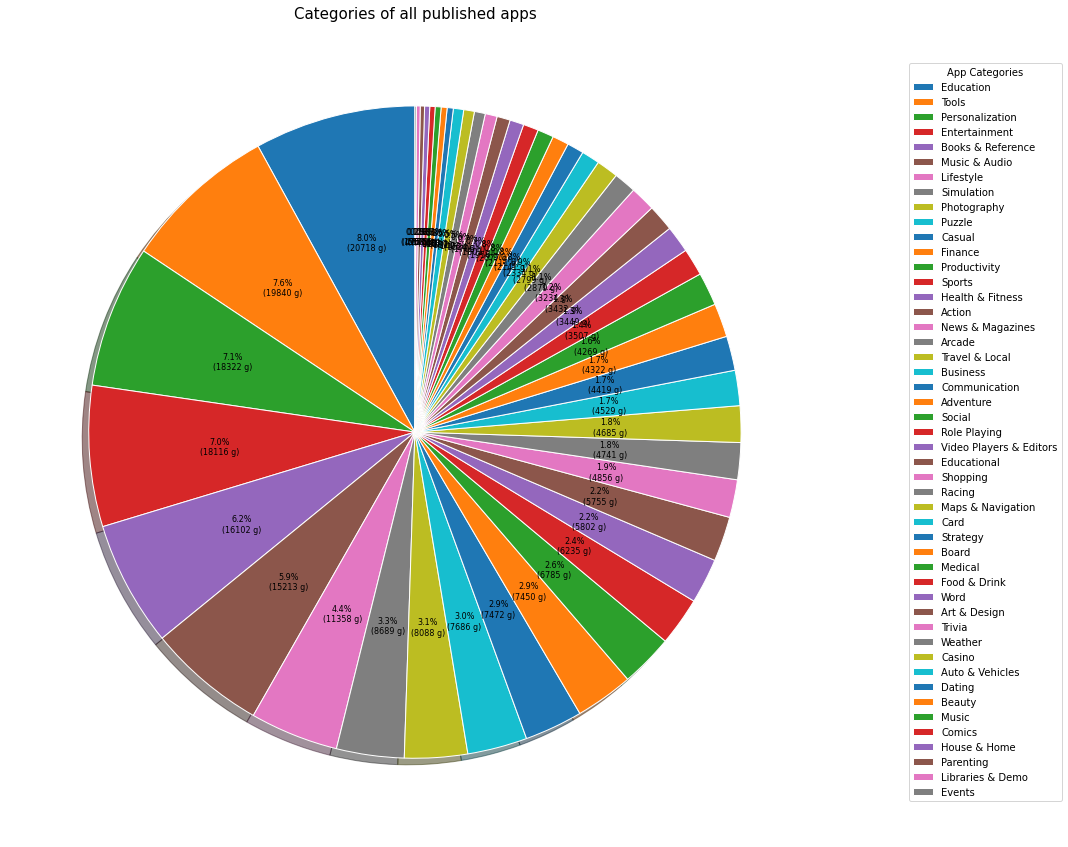

In [32]:
# Wedge properties 
wp = { 'linewidth' : 1, 'edgecolor' : "white" } 
  
# Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize = (20,15)) 
wedges, texts, autotexts = ax.pie(DataCat,  
                                  autopct = lambda pct: func(pct, DataCat), 
                                  shadow = True, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
                                 ) 
  
# Adding legend 
ax.legend(wedges, LabelsCat, 
          title ="App Categories", 
          loc ="center left", 
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 8) 
ax.set_title("Categories of all published apps", fontsize=15) 
  
# show plot 
plt.show() 

In [33]:
BigCat = Cat.nlargest(9)
SmallCat = pd.Series(Cat.nsmallest(39).sum(),index=['Other'])
AllCat = BigCat.append(SmallCat)
LabelsAllCat = AllCat.index
DataAllCat = AllCat.values

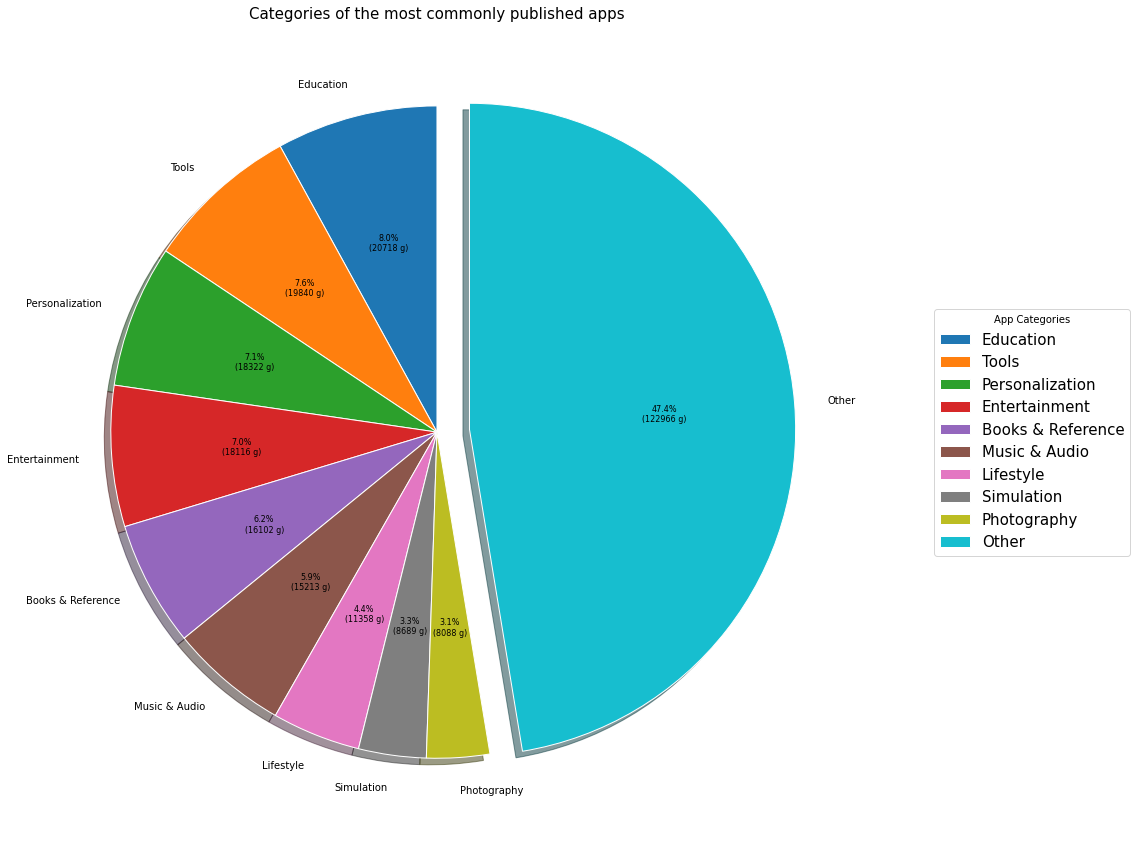

In [34]:
# Creating explode data 
explode = (0,0,0,0,0,0,0,0,0,.1) 
  
# Creating color parameters 
# colors = ( "orange", "cyan", "brown", 
#           "grey", "indigo", "beige") 
  
# Wedge properties 
# wp = { 'linewidth' : 1, 'edgecolor' : "white" } 
  
# Creating autocpt arguments 
# def func(pct, allvalues): 
#     absolute = int(pct / 100.*np.sum(allvalues)) 
#     return "{:.1f}%\n({:d} g)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize = (15,15)) 
wedges, texts, autotexts = ax.pie(DataAllCat,  
                                  autopct = lambda pct: func(pct, DataAllCat), 
                                  explode = explode,  
                                  labels = LabelsAllCat, 
                                  shadow = True, 
#                                   colors = colors, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
#                                   textprops = dict(color ="magenta")
                                 ) 
  
# Adding legend 
ax.legend(wedges, LabelsAllCat, 
          title ="App Categories", 
          loc ="center left", 
          prop={'size': 15},
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 8) 
ax.set_title("Categories of the most commonly published apps", fontsize=15) 
  
# show plot 
plt.show() 

In [35]:
LabelsBigCat = BigCat.index
DataBigCat = BigCat.values

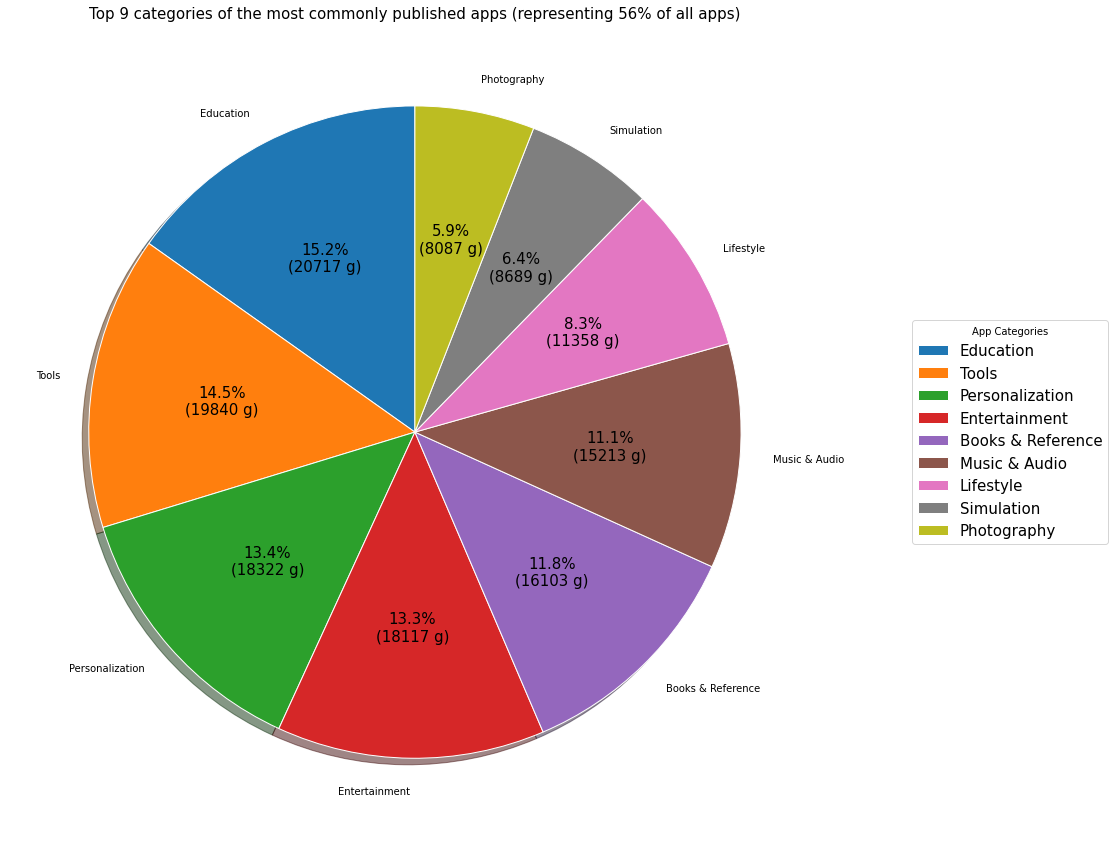

In [36]:
# Creating plot 
fig, ax = plt.subplots(figsize = (20,15)) 
wedges, texts, autotexts = ax.pie(DataBigCat,  
                                  autopct = lambda pct: func(pct, DataBigCat), 
                                  labels = LabelsBigCat, 
                                  shadow = True, 
                                  startangle = 90, 
                                  wedgeprops = wp,
                                 ) 
  
# Adding legend 
ax.legend(wedges, LabelsBigCat, 
          title ="App Categories",
          prop={'size': 15},
          loc ="center left", 
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 15) 
ax.set_title("Top 9 categories of the most commonly published apps (representing 56% of all apps)", fontsize=15)  
  
# show plot 
plt.show() 

In [37]:
x = df[df['Category'].isin(LabelsBigCat)]
z = x.groupby(['Category']).count()['Rating'].index
x = x.groupby(['Category','Ad Supported']).count()['Rating']
y = x.values
y = y.reshape((9,2))

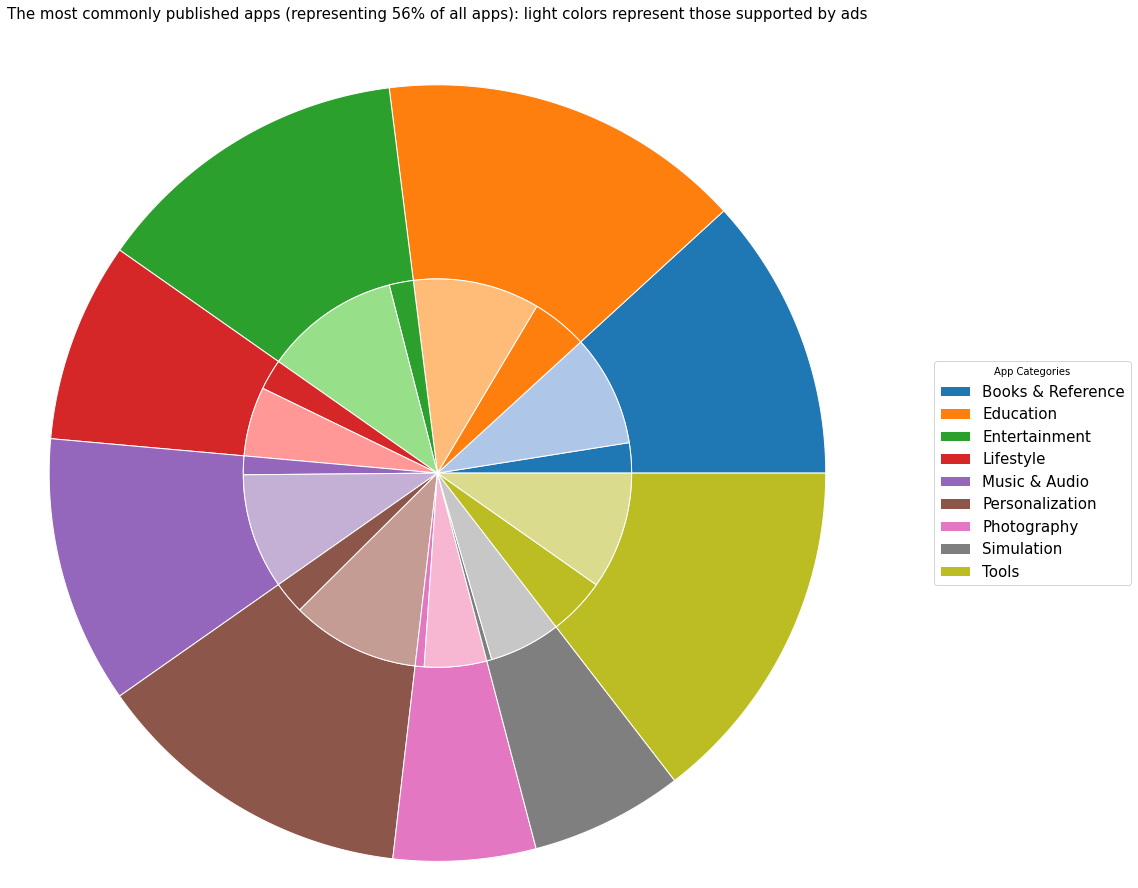

In [38]:
size=6

# Wedge properties 
wp = { 'linewidth' : 1, 'edgecolor' : "white" } 

# Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 

# normalizing data to 2 pi 
norm = y / np.sum(y)*2 * np.pi 
  
# obtaining ordinates of bar edges 
left = np.cumsum(np.append(0,  
                           norm.flatten()[:-1])).reshape(y.shape) 
  
# Creating color scale 
cmap = plt.get_cmap("tab20") 
outer_colors = cmap(np.arange(9)*2) 
inner_colors = cmap(np.arange(18)*1) 
  
# Creating plot 
fig, ax = plt.subplots(figsize = (15,15), 
    subplot_kw = dict(polar = True)) 
    
    
    
ax.bar(x = left[:, 0], 
       width = norm.sum(axis = 1), 
       bottom = 1-size, 
       height = size, 
       color = outer_colors,  
       edgecolor ='w', 
       linewidth = 1, 
       align ="edge") 
  
ax.bar(x = left.flatten(), 
       width = norm.flatten(), 
       bottom = 1-2 * size, 
       height = size, 
       color = inner_colors, 
       edgecolor ='w', 
       linewidth = 1, 
       align ="edge") 
  
    
# Adding legend 
ax.legend(wedges, z, 
          title ="App Categories", 
          loc ="center left", 
          prop={'size': 15},
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
    
plt.setp(autotexts, size = 15) 
ax.set_title("The most commonly published apps (representing 56% of all apps): light colors represent those supported by ads", fontsize=15) 
ax.set_axis_off() 

# show plot 
plt.show() 

# Since we don't have metrics like profits, we'll have to use "Rating" as the best quantifier of how successful an app is.  Here are the initial correlation metrics.  None by themselves have strong correlations, so there's probably a more complex correlation to "Rating".

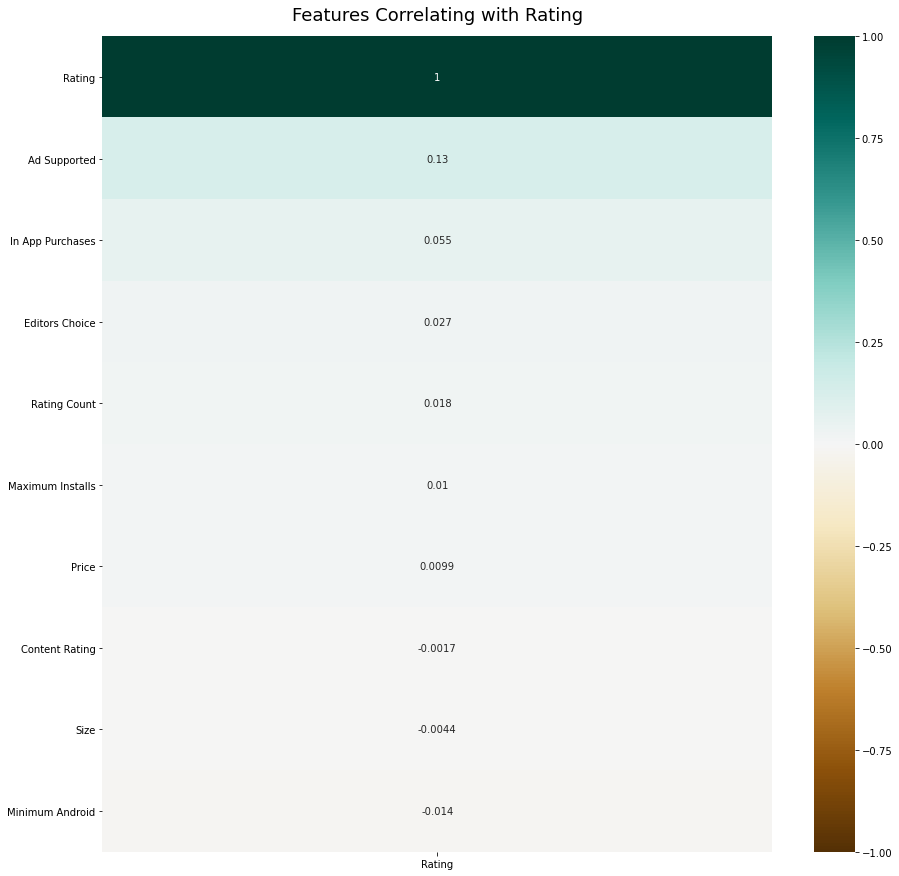

In [39]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(df.corr()[['Rating']].sort_values(by='Rating', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Rating', fontdict={'fontsize':18}, pad=16);

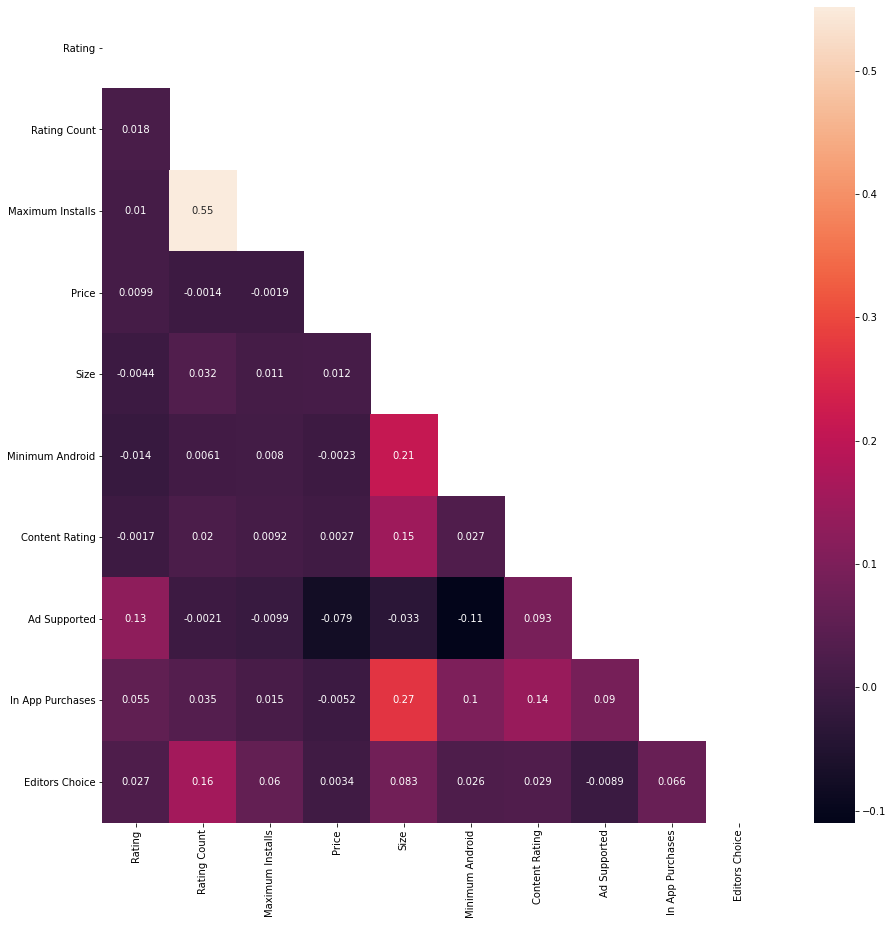

In [40]:
f, ax = plt.subplots(figsize=(15, 15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix)

# The Rating has a median value of 4.2 with an interquartile range of 3.8 to 4.4.  It has a mean of 4.0.

[Text(0.5, 0, '')]

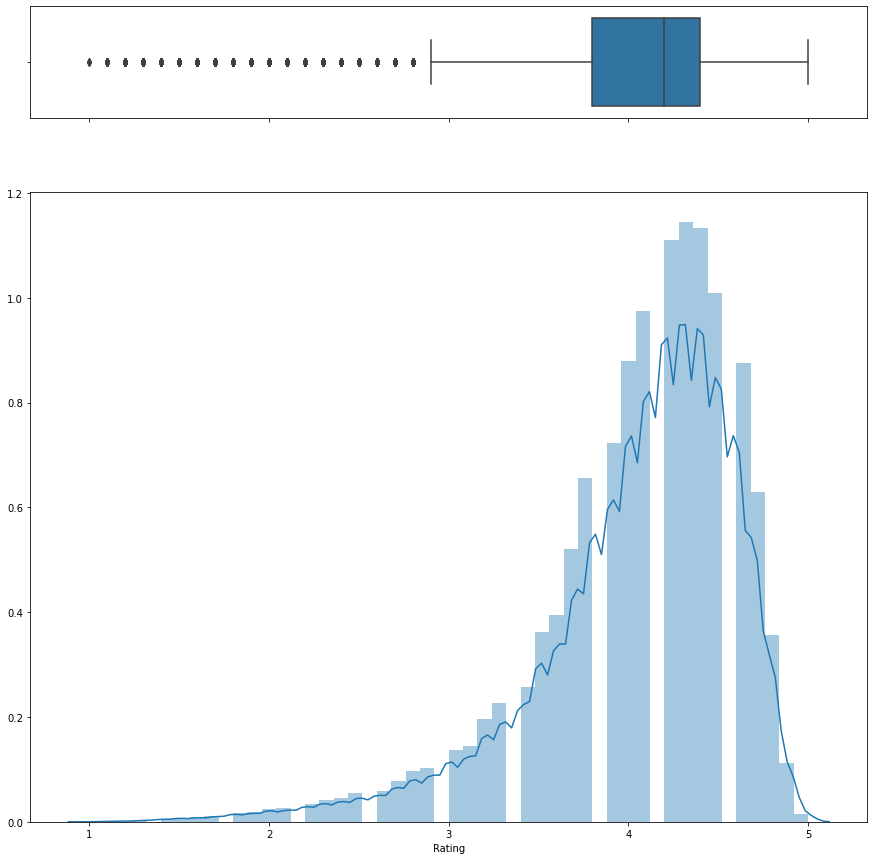

In [41]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,15) )
 
# Add a graph in each part
sns.boxplot(df["Rating"], ax=ax_box)
sns.distplot(df["Rating"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


In [42]:
df['Rating'].describe()

count    259419.000000
mean          4.046281
std           0.560048
min           1.000000
25%           3.800000
50%           4.200000
75%           4.400000
max           5.000000
Name: Rating, dtype: float64

# Rating V Category
## We'll look at the nine most popular categories we isolated earlier in the pie chart for simplicity.  Books/Reference has the top mean rating at 4.4, and Simulation has the lowest at 3.8.

In [43]:
x = df[df['Category'].isin(LabelsBigCat)]
x.groupby('Category').describe()

Rating                                               \
                     count      mean       std  min  25%  50%  75%  max   
Category                                                                  
Books & Reference  16103.0  4.360094  0.460999  1.3  4.2  4.5  4.7  5.0   
Education          20718.0  4.179945  0.522859  1.2  4.0  4.3  4.5  5.0   
Entertainment      18117.0  3.947960  0.578526  1.0  3.7  4.1  4.4  5.0   
Lifestyle          11359.0  4.099850  0.626397  1.0  3.9  4.3  4.5  5.0   
Music & Audio      15214.0  4.257999  0.481552  1.3  4.1  4.4  4.6  5.0   
Personalization    18323.0  4.243535  0.399797  1.2  4.1  4.3  4.5  5.0   
Photography         8088.0  3.892124  0.575123  1.1  3.7  4.0  4.3  5.0   
Simulation          8689.0  3.814409  0.476310  1.2  3.5  3.9  4.1  5.0   
Tools              19841.0  3.912066  0.604386  1.1  3.6  4.1  4.3  5.0   

                  Rating Count                                             \
                         count          mean            std    min    25%   
Category                                                                    
Books & Reference      16103.0   3589.376265   33220.105128  101.0  188.0   
Education              20718.0   3991.809103   76610.810717  101.0  198.0   
Entertainment          18117.0   9101.570679  139284.631024  101.0  211.0   
Lifestyle              11359.0   6526.336297   87870.862043  101.0  212.0   
Music & Audio          15214.0  10052.698764  195548.945098  101.0  189.0   
Personalization        18323.0   5949.483818   93949.422779  101.0  217.0   
Photography             8088.0  24732.896761  407718.924906  101.0  241.0   
Simulation              8689.0  22891.799747  154527.542618  101.0  417.0   
Tools                  19841.0  19777.428255  335949.047386  101.0  255.0   

                                               Maximum Installs                \
                      50%      75%         max            count          mean   
Category                                                                        
Books & Reference   386.0  1105.00   1738589.0          16103.0  5.099400e+05   
Education           422.0  1206.00  10199634.0          20718.0  3.796572e+05   
Entertainment       508.0  1786.00  11424624.0          18117.0  1.241013e+06   
Lifestyle           491.0  1644.00   7229303.0          11359.0  6.856683e+05   
Music & Audio       391.5  1257.00  20845533.0          15214.0  1.459555e+06   
Personalization     521.0  1711.00   7561312.0          18323.0  6.731725e+05   
Photography         668.0  2904.75  30472376.0           8088.0  3.342950e+06   
Simulation         1448.0  6706.00   7950274.0           8689.0  1.851366e+06   
Tools               723.0  3008.00  32425599.0          19841.0  4.335820e+06   

                                                                          \
                            std      min       25%       50%         75%   
Category                                                                   
Books & Reference  2.450375e+07  10002.0  31773.00   65118.0   160109.50   
Education          2.776897e+06  10001.0  35629.25   77090.0   199509.00   
Entertainment      3.392042e+07  10001.0  46603.00  118051.0   369952.00   
Lifestyle          8.210825e+06  10001.0  40980.50   97316.0   275280.50   
Music & Audio      5.431422e+07  10001.0  31160.00   68986.0   196224.50   
Personalization    5.944474e+06  10001.0  37754.50   88564.0   281117.50   
Photography        6.110599e+07  10005.0  75541.00  202823.0   800569.25   
Simulation         6.564109e+06  10007.0  96558.00  312165.0  1142771.00   
Tools              1.200846e+08  10001.0  46052.00  127260.0   503451.00   

                                   Price                                     \
                            max    count      mean       std  min  25%  50%   
Category                                                                      
Books & Reference  3.077276e+09  16103.0  0.035669  0.624381  0.0  0.0 

In [44]:
x.groupby('Category')['Rating'].mean().sort_values(ascending=False)

Category
Books & Reference    4.360094
Music & Audio        4.257999
Personalization      4.243535
Education            4.179945
Lifestyle            4.099850
Entertainment        3.947960
Tools                3.912066
Photography          3.892124
Simulation           3.814409
Name: Rating, dtype: float64

In [45]:
# Take the log of rating count, price, size
df['Log Rating Count'] = np.log10(df['Rating Count'])
df['Log Price'] = (np.log10(df['Price'])).replace([np.inf, -np.inf], np.nan).fillna(0)
df['Log Size'] = np.log10(df['Size'])
df['Log Maximum Installs'] = np.log10(df['Maximum Installs'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
labels = LabelsBigCat.sort_values().values.tolist()
overall = x.groupby('Category')['Rating'].mean().values
aTpT = x[(x['Ad Supported'] == True)&(x['In App Purchases'] == True)].groupby('Category')['Rating'].mean().values        
aTpF = x[(x['Ad Supported'] == True)&(x['In App Purchases'] == False)].groupby('Category')['Rating'].mean().values     
aFpT = x[(x['Ad Supported'] == False)&(x['In App Purchases'] == True)].groupby('Category')['Rating'].mean().values   
aFpF = x[(x['Ad Supported'] == False)&(x['In App Purchases'] == False)].groupby('Category')['Rating'].mean().values   
editorsT = x[x['Editors Choice'] == True].groupby('Category')['Rating'].mean().values.tolist()
editorsT.insert(5,0)
editorsF = x[x['Editors Choice'] == False].groupby('Category')['Rating'].mean().values

compound = [aTpT,aTpF, aFpT, aFpF]

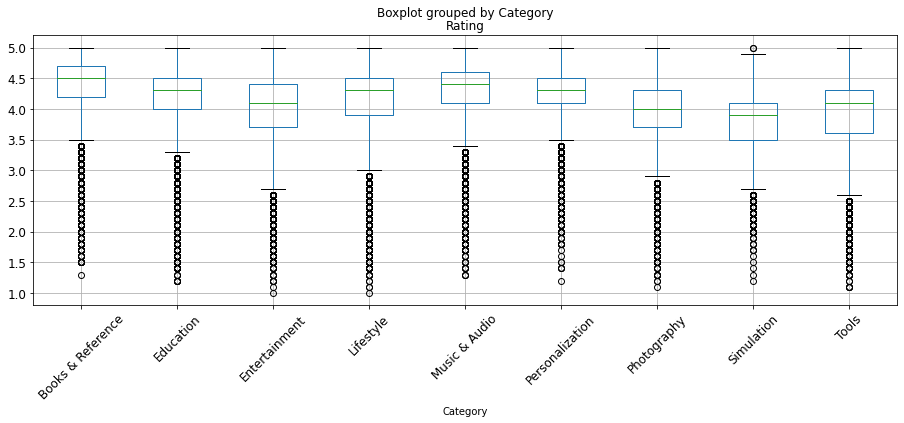

In [47]:
x.boxplot(column='Rating',by='Category',rot=45, fontsize=12, figsize=(15,5))

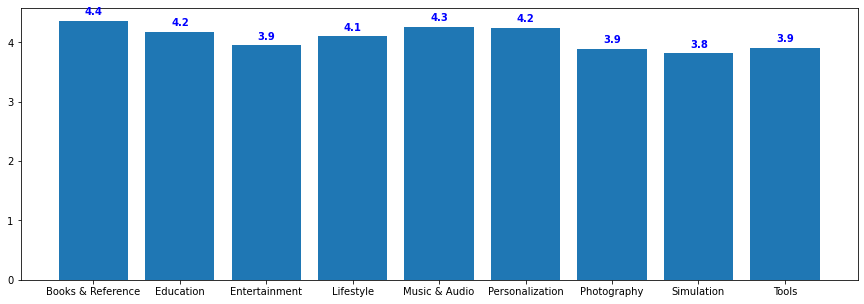

In [48]:
fig, ax = plt.subplots(figsize = (15,5))
n=np.arange(9)
labels = LabelsBigCat.sort_values().values.tolist()
plt.bar(n, overall)
plt.xticks(n, labels)

for i, v in enumerate(overall):
    ax.text(i - .1, v + .1, round(v, 1), color='blue', fontweight='bold')

plt.show()


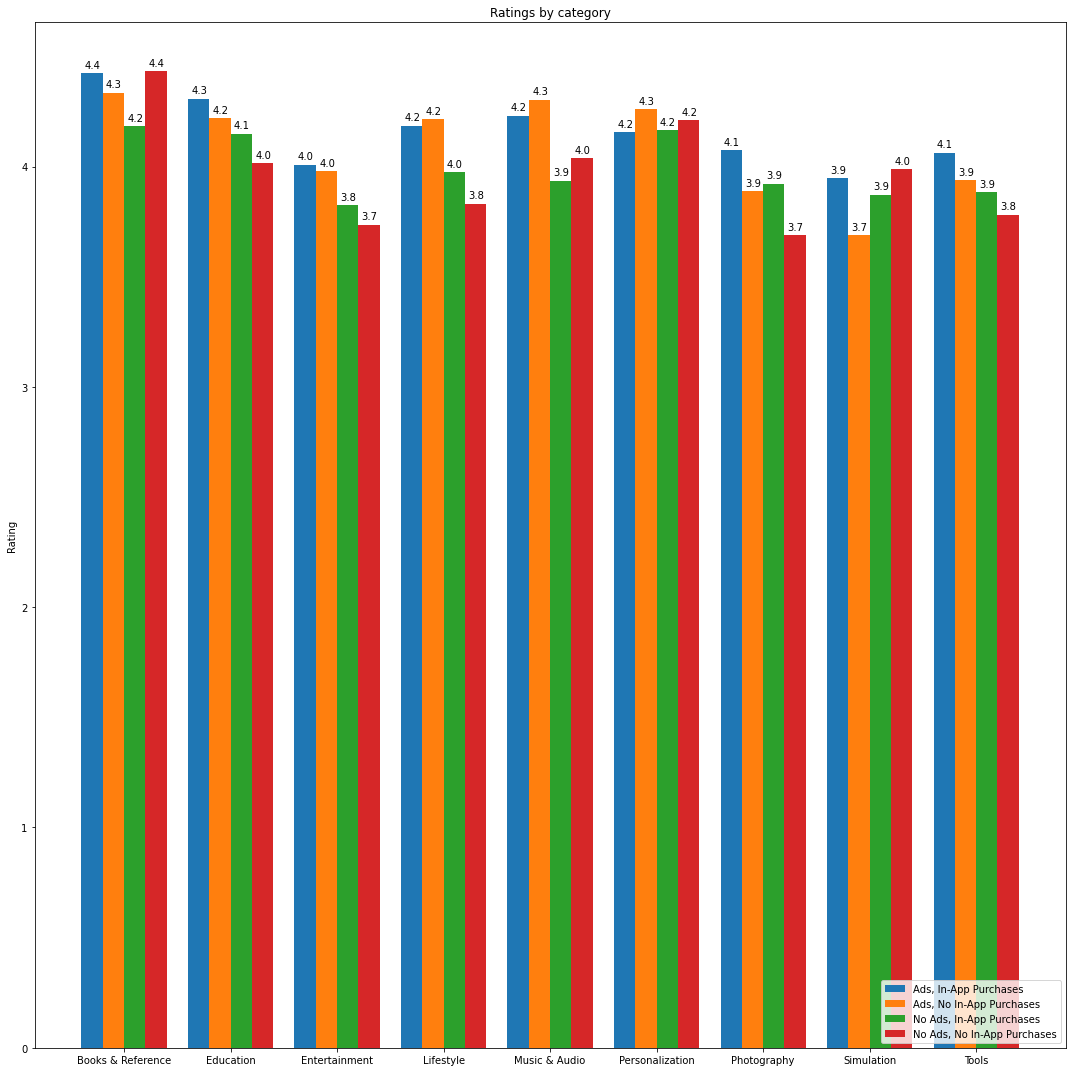

In [49]:
n = 9
y = np.arange(n)  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize = (15,15))
rects1 = ax.bar(y- 1.5*width, aTpT, width, label='Ads, In-App Purchases')
rects2 = ax.bar(y- .5*width, aTpF, width, label='Ads, No In-App Purchases')
rects3 = ax.bar(y+ .5*width, aFpT, width, label='No Ads, In-App Purchases')
rects4 = ax.bar(y+ 1.5*width, aFpF, width, label='No Ads, No In-App Purchases')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rating')
ax.set_title('Ratings by category')
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend(loc = 'lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height.round(1)),
                    xy=(rect.get_x() + rect.get_width() , height),
                    xytext=(-10, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

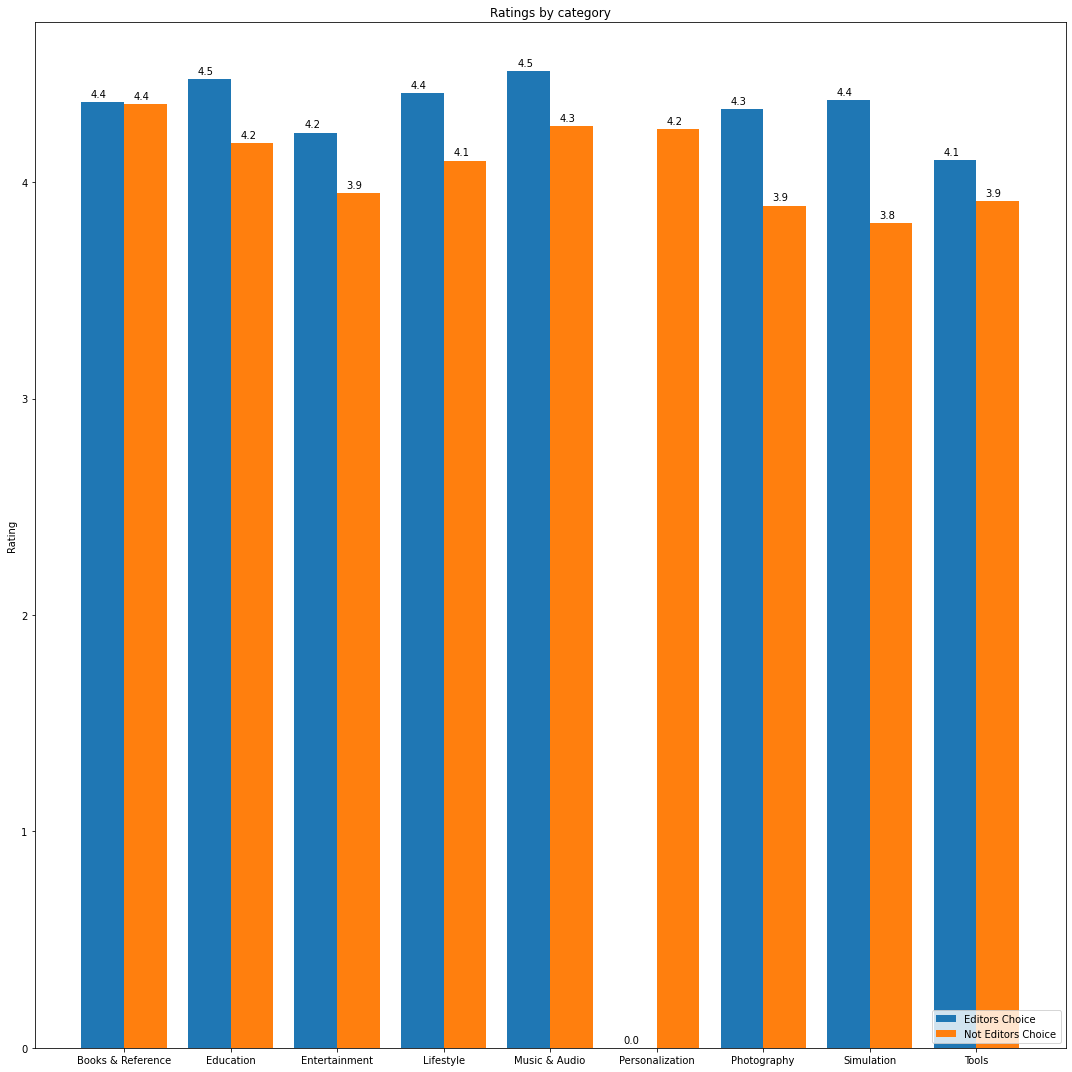

In [50]:
n = 9
y = np.arange(n)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize = (15,15))
rects5 = ax.bar(y-.5*width, editorsT, width, label='Editors Choice')
rects6 = ax.bar(y+.5*width, editorsF, width, label='Not Editors Choice')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rating')
ax.set_title('Ratings by category')
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend(loc = 'lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height.round(1)),
                    xy=(rect.get_x() + rect.get_width() , height),
                    xytext=(-25, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects5)
autolabel(rects6)

fig.tight_layout()

plt.show()

# Rating V Rating Count/# of Installs (similar metrics)
## These scatterplots are very similar in shape, as to be expected.

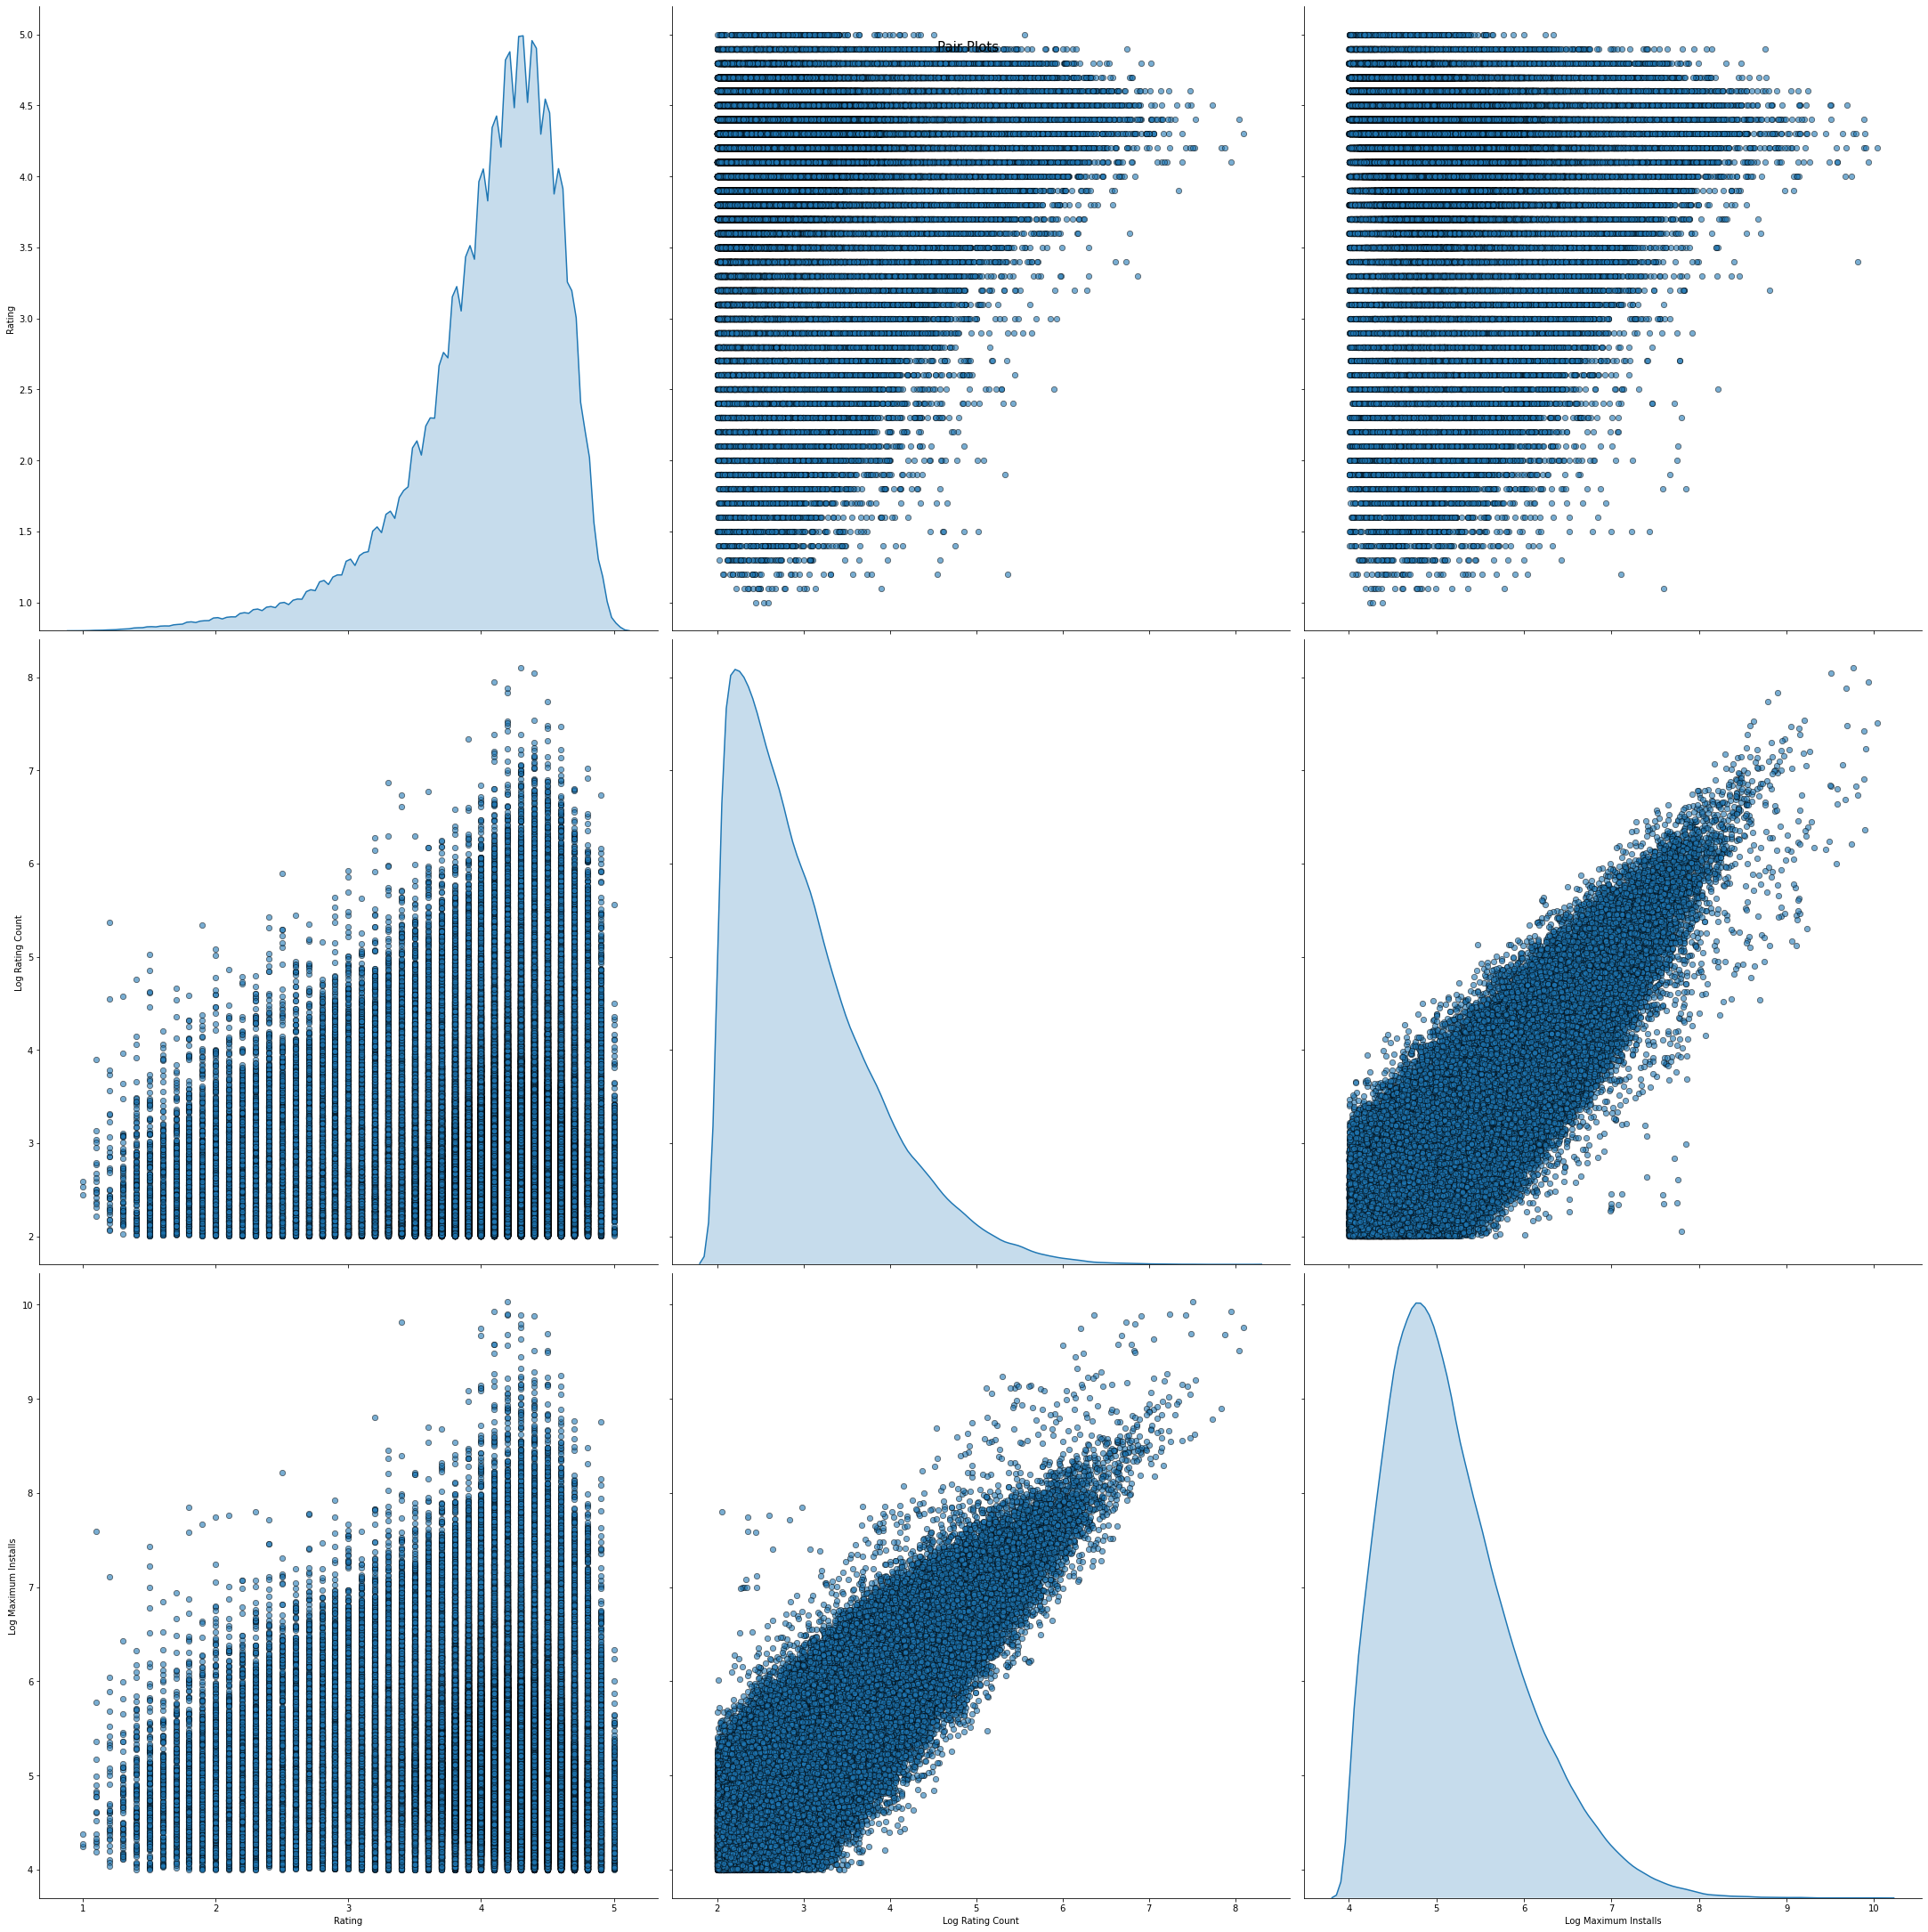

In [51]:
sns.pairplot(df, 
             vars = ['Rating', 'Log Rating Count', 'Log Maximum Installs'],
             diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 40, 'edgecolor': 'k'},
             height = 10);
# Title 
plt.suptitle('Pair Plots', 
             size = 15);

[Text(0.5, 0, '')]

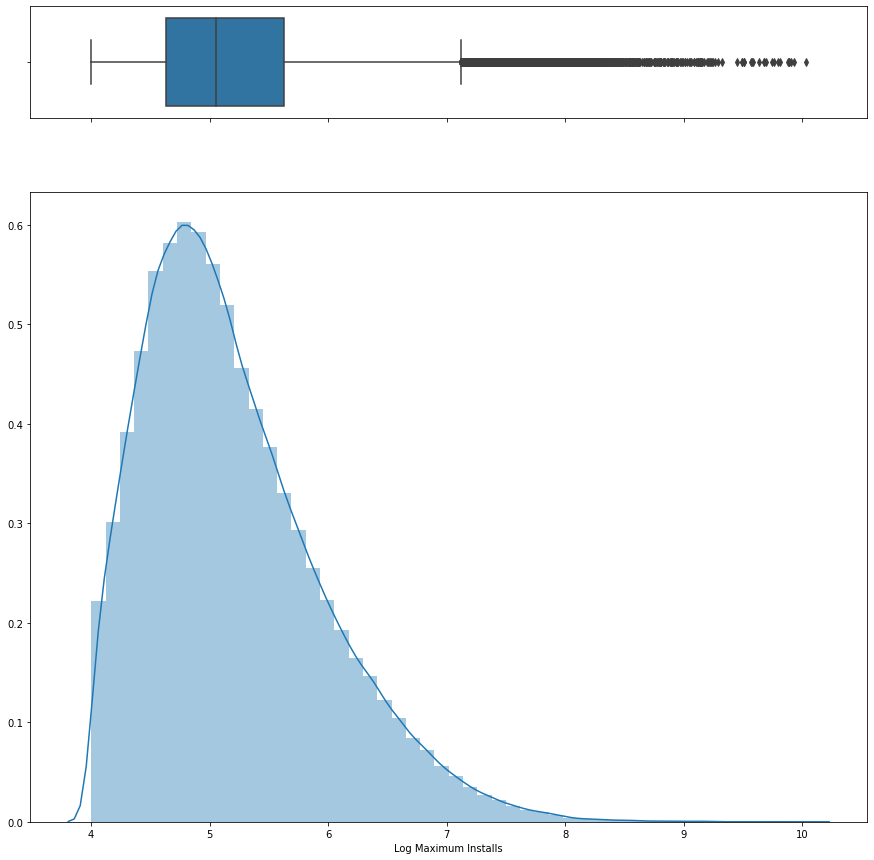

In [52]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,15) )
 
# Add a graph in each part
sns.boxplot(df["Log Maximum Installs"], ax=ax_box)
sns.distplot(df["Log Maximum Installs"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


[Text(0.5, 0, '')]

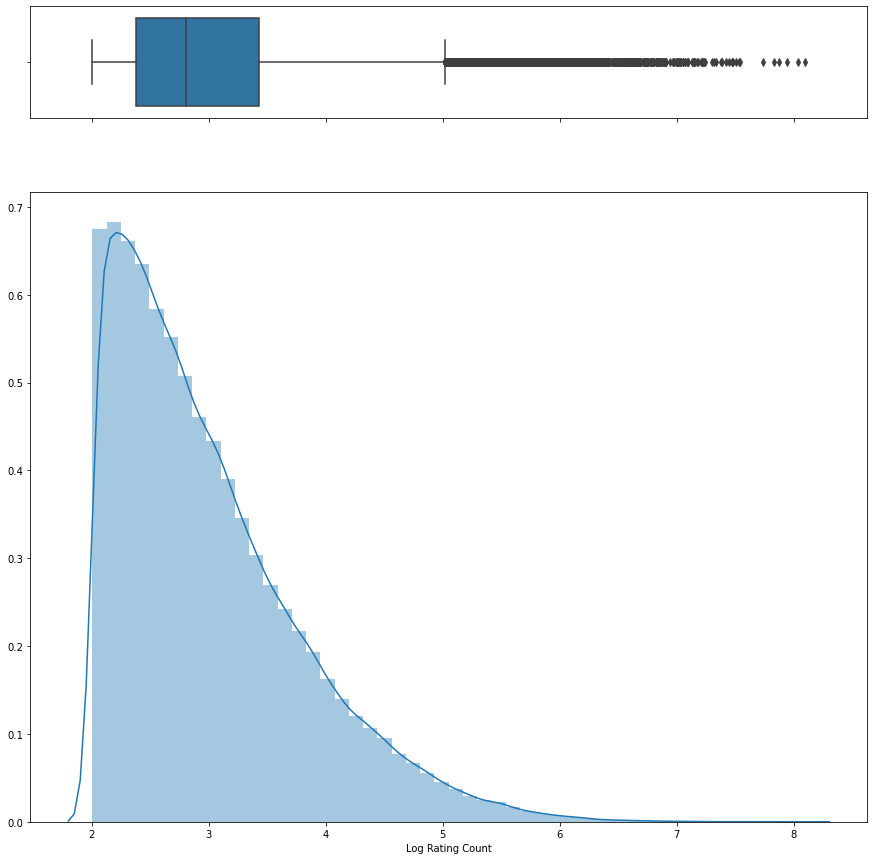

In [53]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,15) )
 
# Add a graph in each part
sns.boxplot(df["Log Rating Count"], ax=ax_box)
sns.distplot(df["Log Rating Count"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


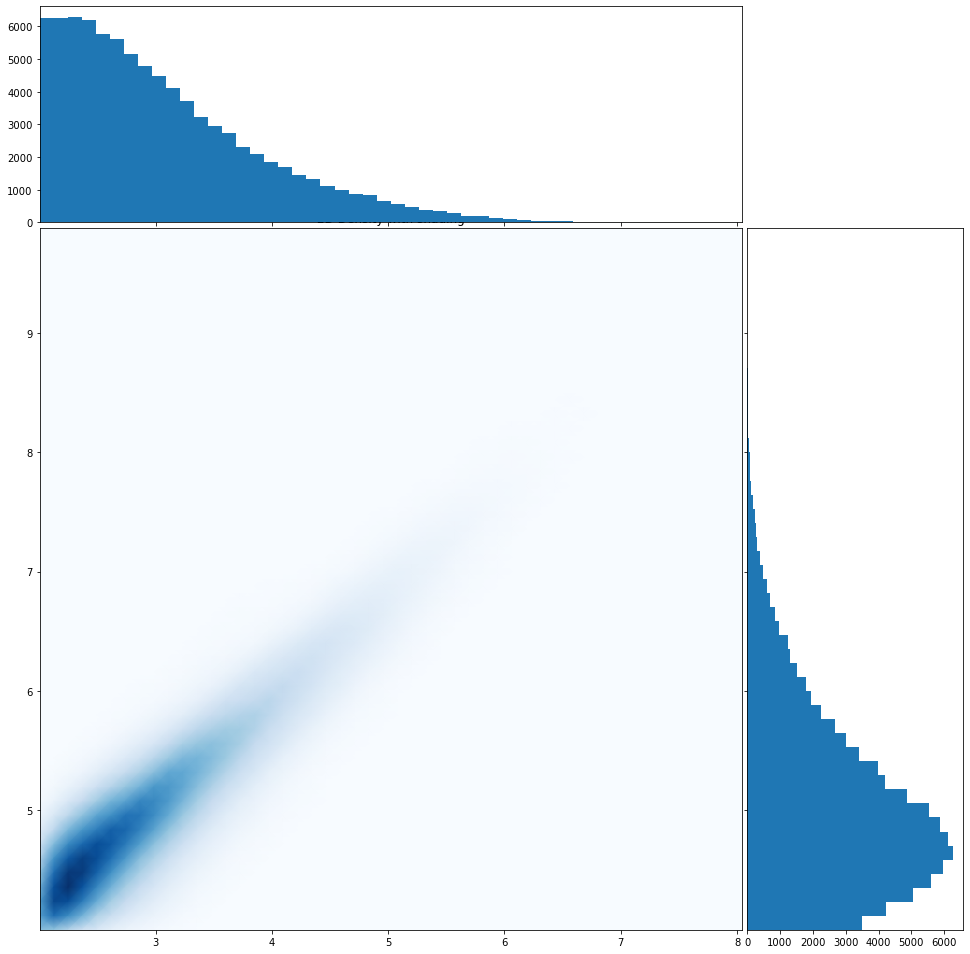

In [54]:
x = df['Log Rating Count'][df['Rating'] > 4.3]
y = df['Log Maximum Installs'][df['Rating'] > 4.3]


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
#     ax.scatter(x, y, alpha=.3, s=1)
    nbins=50
    xx = df['Log Rating Count'][df['Rating'] > 4.3]
    yy = df['Log Maximum Installs'][df['Rating'] > 4.3]

    smallerdf = pd.DataFrame({'xx':x, 'yy':y})
    smallerdf = smallerdf.to_numpy()
    xx,yy = smallerdf.T

    k = kde.gaussian_kde(smallerdf.T)

    xi, yi = np.mgrid[xx.min():xx.max():nbins*1j, yy.min():yy.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # add shading
    ax.set_title('2D Density with shading')
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Blues')

    # now determine nice limits by hand:
#     bins = np.arange(-.1, 2.1, .05)
    ax_histx.hist(x, bins=50)
    ax_histy.hist(y, bins=50, orientation='horizontal')

    
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()



In [55]:
df['Rating Count'][df['Rating'] > 4.3].describe()



count    8.573300e+04
mean     3.056642e+04
std      5.503694e+05
min      1.010000e+02
25%      2.620000e+02
50%      7.640000e+02
75%      3.545000e+03
max      1.095933e+08
Name: Rating Count, dtype: float64

In [56]:
df['Maximum Installs'][df['Rating'] > 4.3].describe()

count    8.573300e+04
mean     2.121985e+06
std      4.337538e+07
min      1.000100e+04
25%      3.394800e+04
50%      8.851500e+04
75%      3.320940e+05
max      7.599204e+09
Name: Maximum Installs, dtype: float64

# Rating V Price
## First a look at it with price on a log scale.  Most apps are free with peaks at nice-looking price points like $.99 and a few outliers.  Lower prices should impact rating favorably in general, so some of these apps could see their rating rise if they lowered its price.

count    254723.000000
mean          4.044610
std           0.560613
min           1.000000
25%           3.800000
50%           4.200000
75%           4.400000
max           5.000000
Name: Rating, dtype: float64

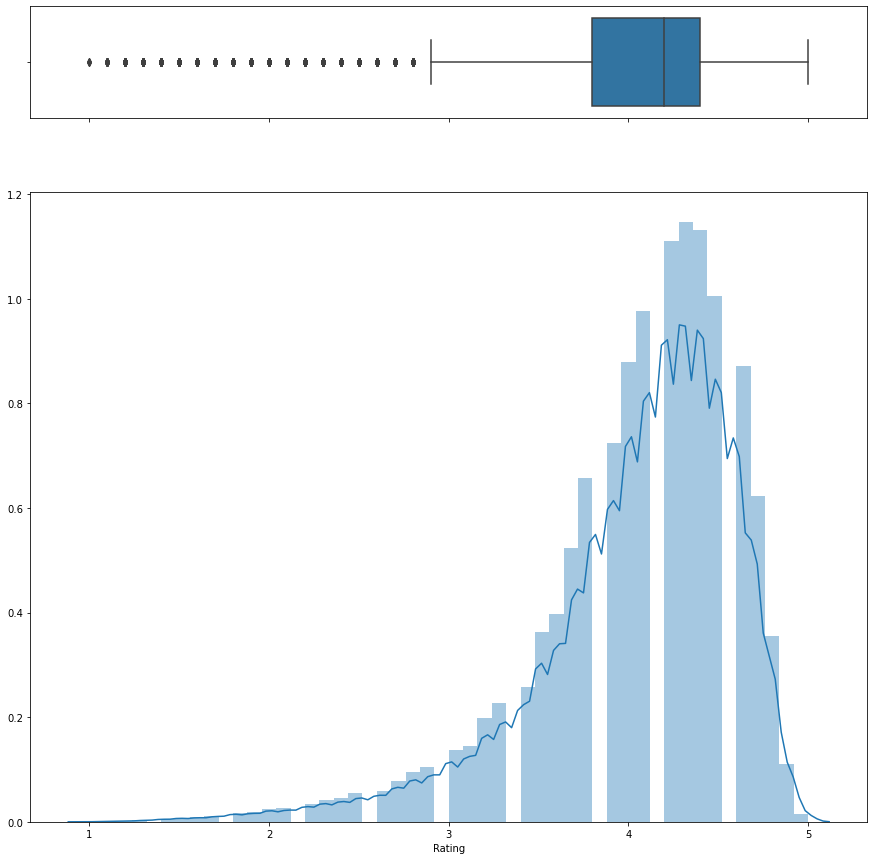

In [89]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,15) )
 
# Add a graph in each part
sns.boxplot(x = df['Rating'][df['Price'] == 0], ax=ax_box)
sns.distplot(df['Rating'][df['Price'] == 0], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
df['Rating'][df['Log Price'] == 0].describe()

## 98% of apps are free.

In [58]:
sp.stats.percentileofscore(df['Price'][df['Rating'] > 4.3], 0.01,  'rank')

97.74299277990971

## 95% of paid apps are under $10.

In [59]:
np.percentile(df['Price'][(0 < df['Price']) & (df['Rating'] > 4.3)], 95)

9.99

## Most high-rated apps cost between $1.49 and $4.99 with the mode at $.99, though there are a few as expensive as $99.99!

In [60]:
df['Price'][(0 < df['Price'])&(df['Rating'] > 4.3)].describe()

count    1935.000000
mean        3.937023
std         4.721251
min         0.990000
25%         1.490000
50%         2.990000
75%         4.990000
max        99.990000
Name: Price, dtype: float64

In [88]:
df['Rating'][(0 < df['Price'])].describe()

count    4704.000000
mean        4.137011
std         0.520461
min         1.400000
25%         3.900000
50%         4.200000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

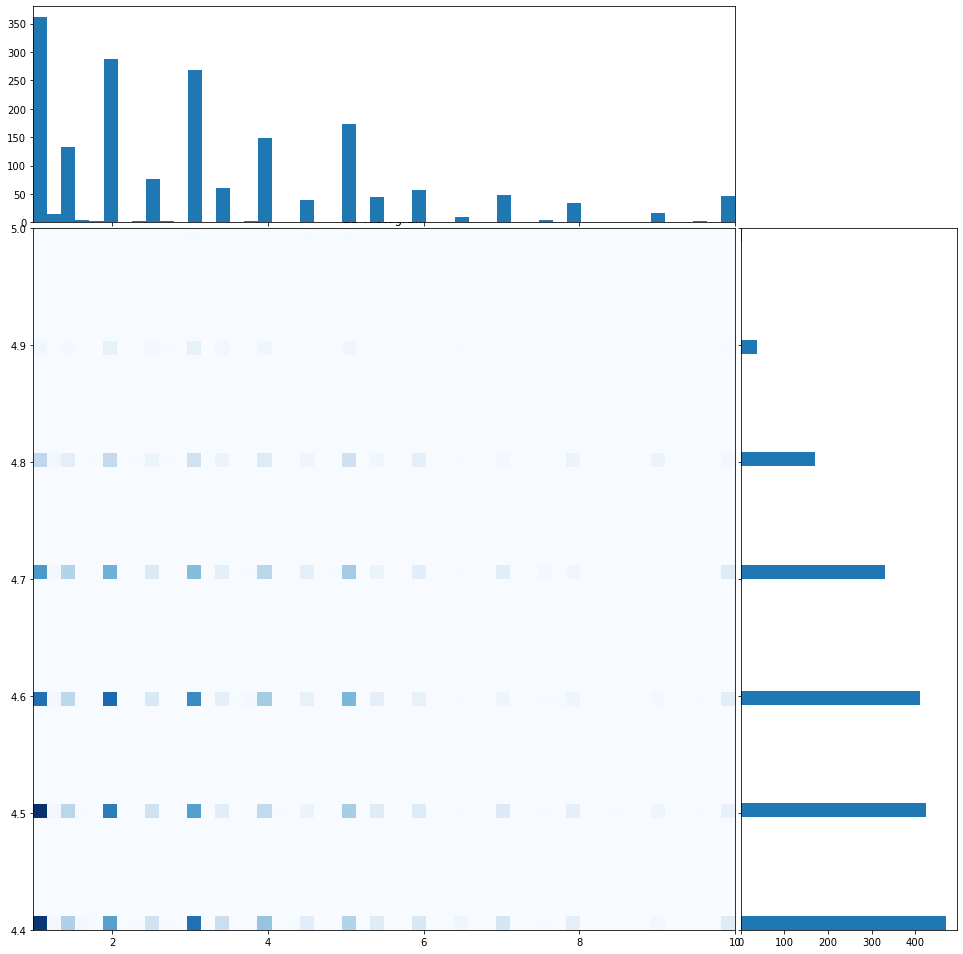

In [61]:
x = (df['Price'][(0 < df['Price']) & (df['Price'] <= 10) & (df['Rating'] > 4.3)])
y = (df['Rating'][(0 < df['Price']) & (df['Price'] <= 10) & (df['Rating'] > 4.3)])

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
#     ax.scatter(x, y, alpha=.3, s=1)
    nbins = 50
    ax.set_title('2D Histogram')
    ax.hist2d(x, y, bins=nbins, cmap='Blues')


    # now determine nice limits by hand:
#     bins = np.arange(-.1, 2.1, .05)
    ax_histx.hist(x, bins=50)
    ax_histy.hist(y, bins=50, orientation='horizontal')

    
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()



## We can verify that these expensive outliers are legit.

In [62]:
df[(df['Price'] > 20) & (df['Rating'] > 4.3)]

App Name  \
App Id                                                                                    
com.AlfaOBD.AlfaOBD                                                             AlfaOBD   
com.tecarta.ZondervanNIVStudyBible                                      NIV Study Bible   
com.boboshi.jagarexamen                                                     Jägarexamen   
com.shabu.startingstrength                                   Starting Strength Official   
handasoft.mobile.divination_pro                            2021 점신PRO : 오늘의 운세, 사주의 완전판   
com.bodunov.GalileoPro                        Guru Maps Pro - Offline Maps & Navigation   
com.podkicker                                                             Podkicker Pro   
com.fourchars.lmp                     LockMyPix Photo Vault PRO: Hide Photos and Videos   
ch.icoaching.wrio                                              Offline Privacy Keyboard   
com.delightgames.delightgamespremium                    Delight Games (Premium Library)   
com.drweb.pro.market                                         Dr.Web Security Space Life   
com.hydrix.laurene                                              Construction Master Pro   
com.calculated.josephine                                     Pipe Trades Pro Calculator   
com.calculated.laurene4050                                        Construction Master 5   

                                               Category  Rating  Rating Count  \
App Id                                                                          
com.AlfaOBD.AlfaOBD                     Auto & Vehicles     4.4           860   
com.tecarta.ZondervanNIVStudyBible    Books & Reference     4.8          1613   
com.boboshi.jagarexamen                       Education     4.8          1268   
com.shabu.startingstrength             Health & Fitness     4.8          2674   
handasoft.mobile.divination_pro               Lifestyle     4.4          3175   
com.bodunov.GalileoPro                Maps & Navigation     4.5          1403   
com.podkicker                             Music & Audio     4.7          5107   
com.fourchars.lmp                           Photography     4.7          5593   
ch.icoaching.wrio                          Productivity     4.6          1399   
com.delightgames.delightgamespremium       Role Playing     4.9          4439   
com.drweb.pro.market                              Tools     4.4          5555   
com.hydrix.laurene                                Tools     4.8          2081   
com.calculated.josephine                          Tools     4.8           218   
com.calculated.laurene4050                        Tools     4.8           641   

                                      Maximum Installs  Price        Size  \
App Id                                                                      
com.AlfaOBD.AlfaOBD                              17575  49.00  22000000.0   
com.tecarta.ZondervanNIVStudyBible               10348  23.99  24000000.0   
com.boboshi.jagarexamen                          14614  24.99  89000000.0   
com.shabu.startingstrength                       23407  24.99  94000000.0   
handasoft.mobile.divination_pro                  33073  28.99  63000000.0   
com.bodunov.GalileoPro                           47259  67.50  67000000.0   
com.podkicker                                    53301  29.99  13000000.0   
com.fourchars.lmp                               102918  99.99   5700000.0   
ch.icoaching.wrio                                16661  24.99  68000000.0   
com.delightgames.delightgamespremium             15589  29.99  22000000.0   
com.drweb.pro.market                             41022  62.29  34000000.0   
com.hydrix.laurene                               91001  29.99   7000000.0   
com.calculated.josephine                         12193  24.99   7500000.0   
com.calculated.laurene4050                       32442  22.99   7600000.0   

                                      Minimum Android   Released Last Updated  \
App Id     

# Rating V Size
## Looking at rating compared to log size in bytes, there's a large peak around 70MB (due to us setting those without values to the median; we could explore this more later).

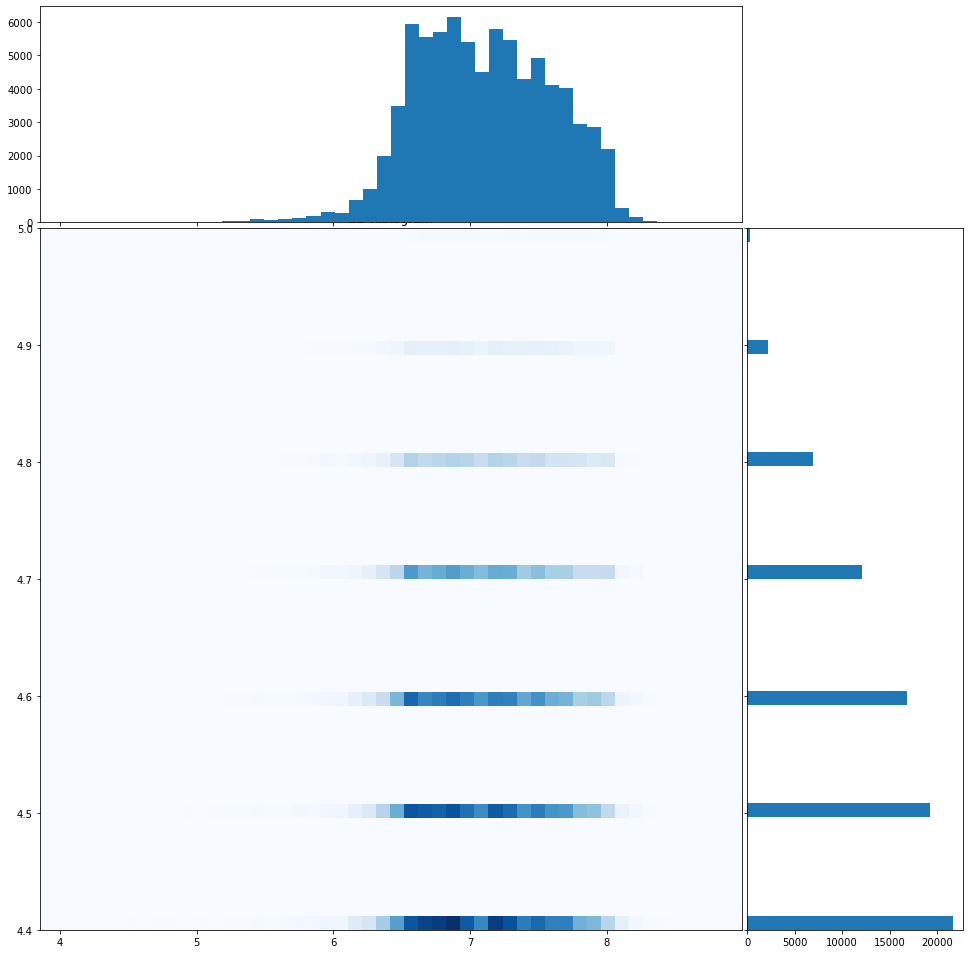

count    7.904200e+04
mean     2.298732e+07
std      2.762025e+07
min      7.100000e+03
25%      5.300000e+06
50%      1.100000e+07
75%      3.100000e+07
max      9.710000e+08
Name: Size, dtype: float64

In [63]:
x = df['Log Size'][(df['Rating'] > 4.3)&(df['Log Size'] != df['Log Size'].median())]
y = df['Rating'][(df['Rating'] > 4.3)&(df['Log Size'] != df['Log Size'].median())]

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
#     ax.scatter(x, y, alpha=.3, s=1)
    nbins = 50
    ax.set_title('2D Histogram')
    ax.hist2d(x, y, bins=nbins, cmap='Blues')


    # now determine nice limits by hand:
#     bins = np.arange(-.1, 2.1, .05)
    ax_histx.hist(x, bins=50)
    ax_histy.hist(y, bins=50, orientation='horizontal')

    
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()

df['Size'][(df['Rating'] > 4.3)&(df['Size'] != df['Size'].median())].describe()

# Rating V Min Required Android Version
## Again, we see a spike at the median due to setting the NaNs to it.  Possibly worth exploring later.

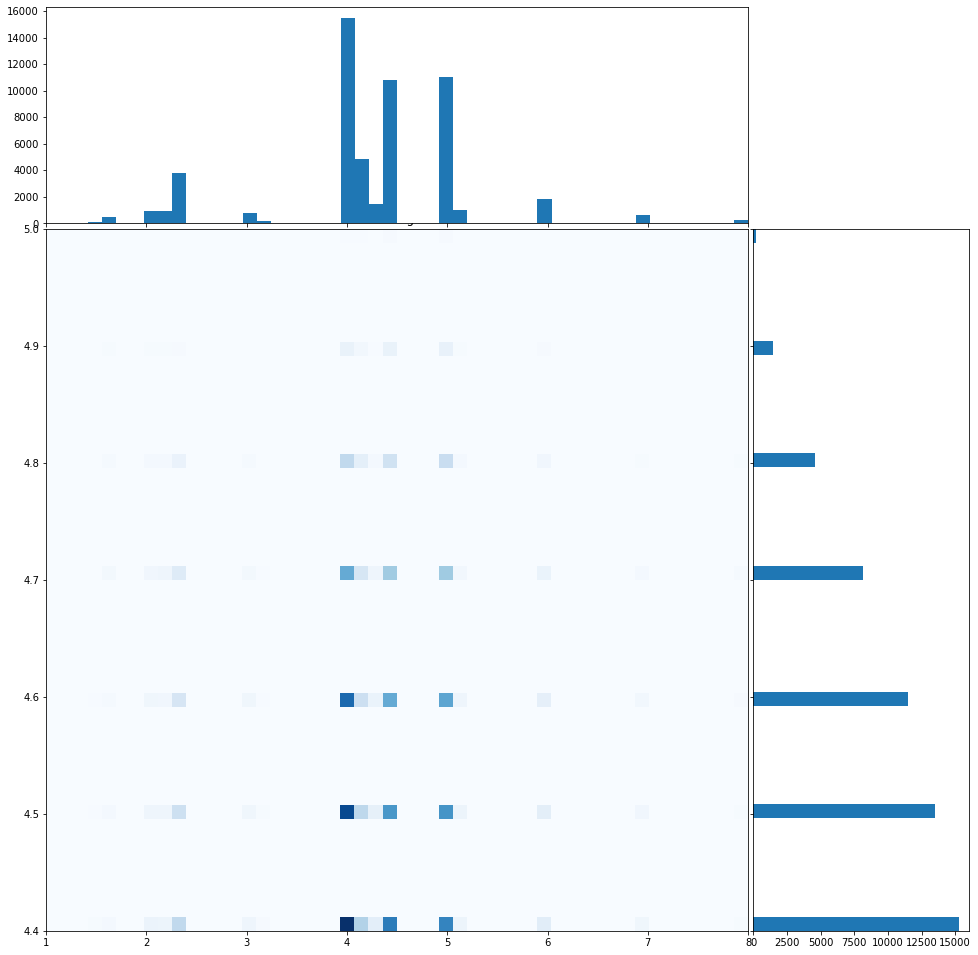

count    54653.000000
mean         4.232177
std          0.967681
min          1.000000
25%          4.000000
50%          4.200000
75%          5.000000
max          8.000000
Name: Minimum Android, dtype: float64

In [64]:
x = df['Minimum Android'][(df['Rating'] > 4.3) & (df['Minimum Android'] != df['Minimum Android'].median())]
y = df['Rating'][(df['Rating'] > 4.3) & (df['Minimum Android'] != df['Minimum Android'].median())]

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
#     ax.scatter(x, y, alpha=.3, s=1)
    nbins = 50
    ax.set_title('2D Histogram')
    ax.hist2d(x, y, bins=nbins, cmap='Blues')


    # now determine nice limits by hand:
#     bins = np.arange(-.1, 2.1, .05)
    ax_histx.hist(x, bins=50)
    ax_histy.hist(y, bins=50, orientation='horizontal')

    
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()

df['Minimum Android'][(df['Rating'] > 4.3) & (df['Minimum Android'] != df['Minimum Android'].median())].describe()

# Rating V Release Date

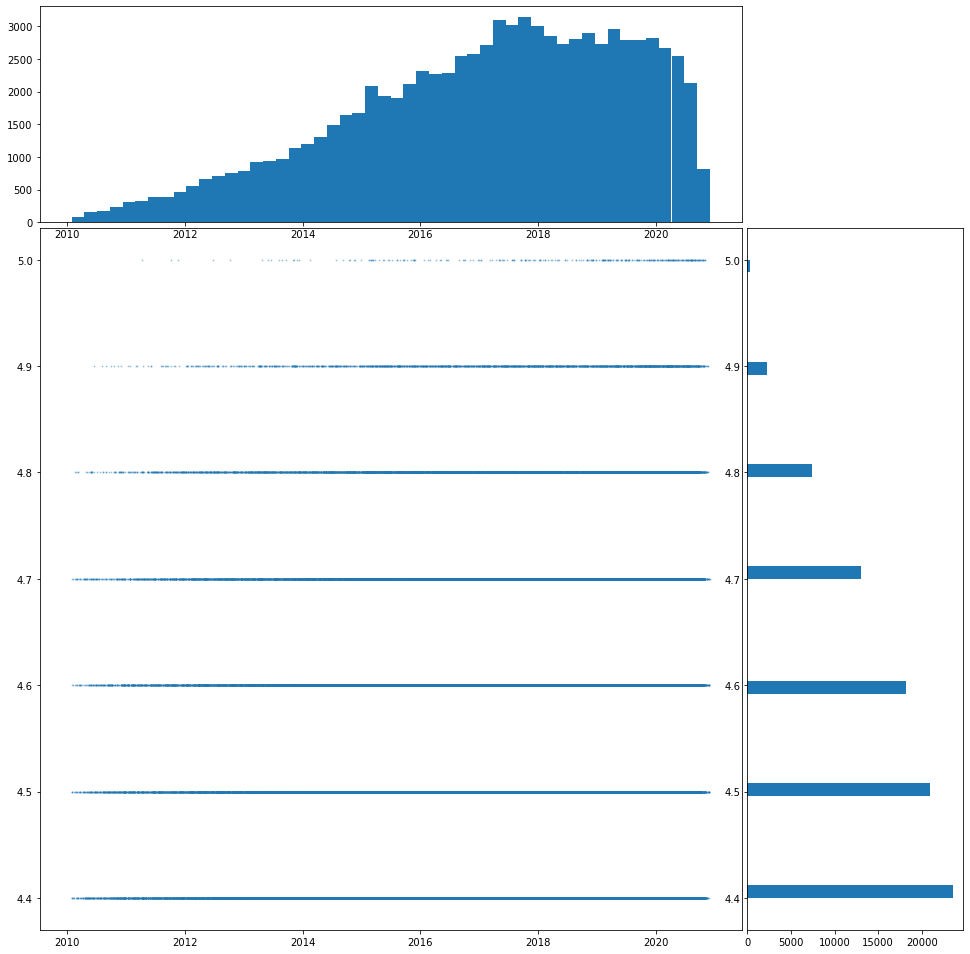

count                   85733
unique                   3889
top       2018-03-01 00:00:00
freq                       68
first     2010-01-28 00:00:00
last      2020-12-01 00:00:00
Name: Released, dtype: object

In [65]:
x = df['Released'][(df['Rating'] > 4.3)]
y = df['Rating'][(df['Rating'] > 4.3)]



def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=True)
    ax_histy.tick_params(axis="y", labelleft=True)

    # the scatter plot:
    ax.scatter(x, y, alpha=.3, s=1)

    # now determine nice limits by hand:
#     binwidth = 0.05
    ax_histx.hist(x, bins=50)
    ax_histy.hist(y, bins=50, orientation='horizontal')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15,15))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()
df['Released'][(df['Rating'] > 4.3)].describe()

In [66]:
# x = df['Released'][(df['Rating'] > 4.3)]
# y = df['Rating'][(df['Rating'] > 4.3)]


# def scatter_hist(x, y, ax, ax_histx, ax_histy):
#     # no labels
#     ax_histx.tick_params(axis="x", labelbottom=False)
#     ax_histy.tick_params(axis="y", labelleft=False)

#     # the scatter plot:
# #     ax.scatter(x, y, alpha=.3, s=1)
#     nbins = 50
#     ax.set_title('2D Histogram')
#     ax.hist2d(x, y, bins=nbins, cmap='Blues')


#     # now determine nice limits by hand:
# #     bins = np.arange(-.1, 2.1, .05)
#     ax_histx.hist(x, bins=50)
#     ax_histy.hist(y, bins=50, orientation='horizontal')

    
    
# # definitions for the axes
# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.005


# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
# rect_histy = [left + width + spacing, bottom, 0.2, height]

# # start with a square Figure
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
# ax_histy = fig.add_axes(rect_histy, sharey=ax)
# # use the previously defined function
# scatter_hist(x, y, ax, ax_histx, ax_histy)

# plt.show()



# Rating V Last Update Date

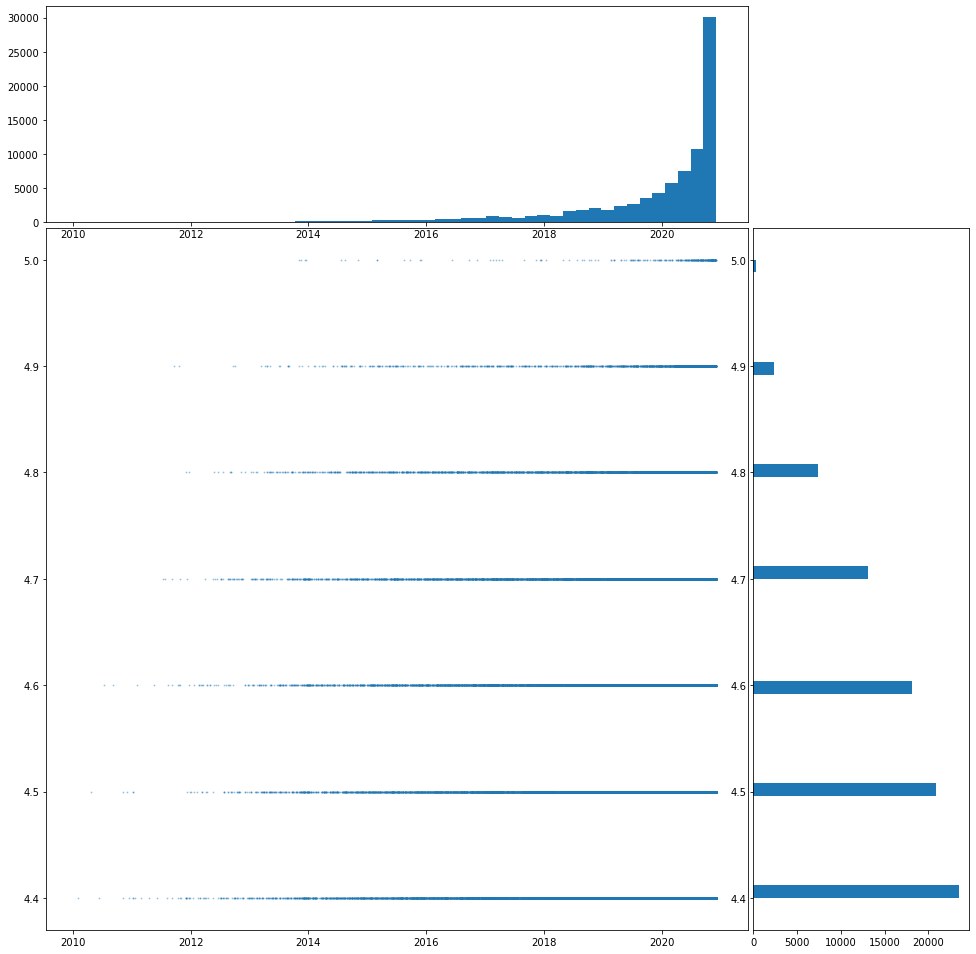

count                   85733
unique                   2840
top       2020-11-27 00:00:00
freq                      997
first     2010-02-02 00:00:00
last      2020-12-03 00:00:00
Name: Last Updated, dtype: object

In [67]:
x = df['Last Updated'][(df['Rating'] > 4.3)]
y = df['Rating'][(df['Rating'] > 4.3)]



def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=True)
    ax_histy.tick_params(axis="y", labelleft=True)

    # the scatter plot:
    ax.scatter(x, y, alpha=.3, s=1)

    # now determine nice limits by hand:
    ax_histx.hist(x, bins=50)
    ax_histy.hist(y, bins=50, orientation='horizontal')

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15,15))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()
df['Last Updated'][(df['Rating'] > 4.3)].describe()

In [68]:
# x = df['Last Updated'][(df['Rating'] > 4.3)]
# y = df['Rating'][(df['Rating'] > 4.3)]


# def scatter_hist(x, y, ax, ax_histx, ax_histy):
#     # no labels
#     ax_histx.tick_params(axis="x", labelbottom=False)
#     ax_histy.tick_params(axis="y", labelleft=False)

#     # the scatter plot:
# #     ax.scatter(x, y, alpha=.3, s=1)
#     nbins = 50
#     ax.set_title('2D Histogram')
#     ax.hist2d(x, y, bins=nbins, cmap='Blues')


#     # now determine nice limits by hand:
# #     bins = np.arange(-.1, 2.1, .05)
#     ax_histx.hist(x, bins=50)
#     ax_histy.hist(y, bins=50, orientation='horizontal')

    
    
# # definitions for the axes
# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.005


# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
# rect_histy = [left + width + spacing, bottom, 0.2, height]

# # start with a square Figure
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
# ax_histy = fig.add_axes(rect_histy, sharey=ax)
# # use the previously defined function
# scatter_hist(x, y, ax, ax_histx, ax_histy)

# plt.show()



# Rating V Content Rating

In [81]:
df.groupby(['Content Rating']).describe()

Rating                                               \
                   count      mean       std  min  25%  50%  75%  max   
Content Rating                                                          
0               213942.0  4.046372  0.571458  1.0  3.8  4.2  4.4  5.0   
10                7356.0  4.036256  0.477656  1.1  3.8  4.1  4.4  5.0   
13               29470.0  4.058616  0.503517  1.3  3.8  4.1  4.4  5.0   
17                8651.0  4.010554  0.519700  1.1  3.7  4.1  4.4  5.0   

               Rating Count                                             \
                      count          mean            std    min    25%   
Content Rating                                                           
0                  213942.0  15899.807158  389275.340520  101.0  228.0   
10                   7356.0  65690.333877  933778.150044  101.0  413.0   
13                  29470.0  43888.802681  944057.841436  101.0  298.0   
17                   8651.0  36302.832621  807881.537684  101.0  254.0   

                                            Maximum Installs                \
                   50%     75%          max            count          mean   
Content Rating                                                               
0                592.0  2349.0  125380770.0         213942.0  1.932881e+06   
10              1590.0  9398.5   54218724.0           7356.0  3.433589e+06   
13              1012.0  5330.5  109593315.0          29470.0  3.888112e+06   
17               735.0  3385.5   68507088.0           8651.0  2.016898e+06   

                                                                       \
                         std      min       25%       50%         75%   
Content Rating                                                          
0               5.470221e+07  10001.0  41228.25  106047.5   377006.25   
10              3.092488e+07  10001.0  59644.50  211289.0  1036880.00   
13              8.771510e+07  10001.0  51854.75  164045.0   717468.25   
17              1.912248e+07  10003.0  50293.50  138844.0   550176.00   

                                 Price                                     \
                         max     count      mean       std  min  25%  50%   
Content Rating                                                              
0               1.077270e+10  213942.0  0.065965  1.365483  0.0  0.0  0.0   
10              1.597811e+09    7356.0  0.155990  0.958448  0.0  0.0  0.0   
13              8.571452e+09   29470.0  0.072752  0.696375  0.0  0.0  0.0   
17              1.060007e+09    8651.0  0.044803  0.591004  0.0  0.0  0.0   

                                 Size                                       \
                75%     max     count          mean           std      min   
Content Rating                                                               
0               0.0  379.99  213942.0  2.085770e+07  2.409484e+07   3300.0   
10              0.0   19.99    7356.0  4.054002e+07  3.961193e+07  38000.0   
13              0.0   29.99   29470.0  3.233275e+07  3.099626e+07  35000.0   
17              0.0   19.99    8651.0  2.466894e+07  2.652517e+07  49000.0   

                                                                  \
                       25%         50%         75%           max   
Content Rating                                                     
0                5500000.0  13000000.0  27000000.0  9.100000e+08   
10              13000000.0  33000000.0  59000000.0  9.710000e+08   
13               9300000.0  21000000.0  48000000.0  1.000000e+09   
17               7100000.0  13000000.0  34000000.0  3.370000e+08   

               Minimum Android                                                \
                         count      mean       std  min   25%  50%  75%  max   
Content Rating                                                                 
0                     213942.0  4.146598  0.842225  1.0  4.03  4.1  4.4  8.0   
10                      7356.0  4.189840  0.

In [82]:
213942/259419

0.8246967261457333

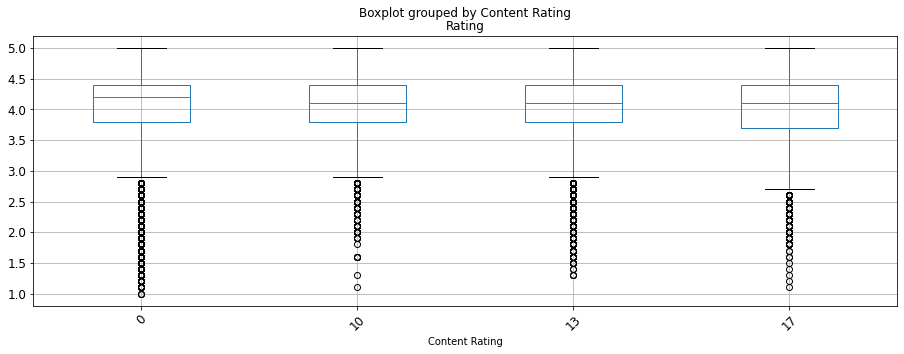

In [79]:
df.boxplot(column='Rating',by='Content Rating',rot=45, fontsize=12, figsize=(15,5))

In [72]:
labels = df.groupby(['Content Rating']).count()['Rating'].index.tolist()

aTpT = df[(df['Ad Supported'] == True)&(df['In App Purchases'] == True)].groupby('Content Rating')['Rating'].mean().values        
aTpF = df[(df['Ad Supported'] == True)&(df['In App Purchases'] == False)].groupby('Content Rating')['Rating'].mean().values        
aFpT = df[(df['Ad Supported'] == False)&(df['In App Purchases'] == True)].groupby('Content Rating')['Rating'].mean().values        
aFpF = df[(df['Ad Supported'] == False)&(df['In App Purchases'] == False)].groupby('Content Rating')['Rating'].mean().values       

editorsT = df[df['Editors Choice'] == True].groupby('Content Rating')['Rating'].mean().values.tolist()
editorsF = df[df['Editors Choice'] == False].groupby('Content Rating')['Rating'].mean().values.tolist()

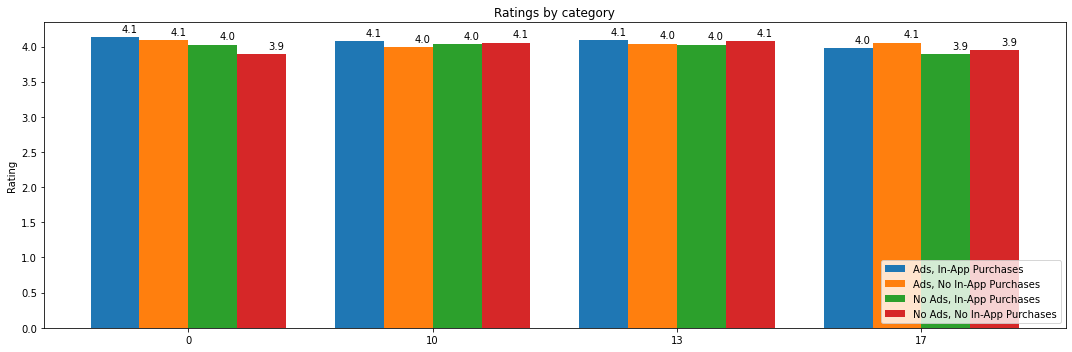

In [75]:
n = 4
y = np.arange(n)  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize = (15,5))
rects1 = ax.bar(y- 1.5*width, aTpT, width, label='Ads, In-App Purchases')
rects2 = ax.bar(y- .5*width, aTpF, width, label='Ads, No In-App Purchases')
rects3 = ax.bar(y+ .5*width, aFpT, width, label='No Ads, In-App Purchases')
rects4 = ax.bar(y+ 1.5*width, aFpF, width, label='No Ads, No In-App Purchases')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rating')
ax.set_title('Ratings by category')
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend(loc = 'lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height.round(1)),
                    xy=(rect.get_x() + rect.get_width() , height),
                    xytext=(-10, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

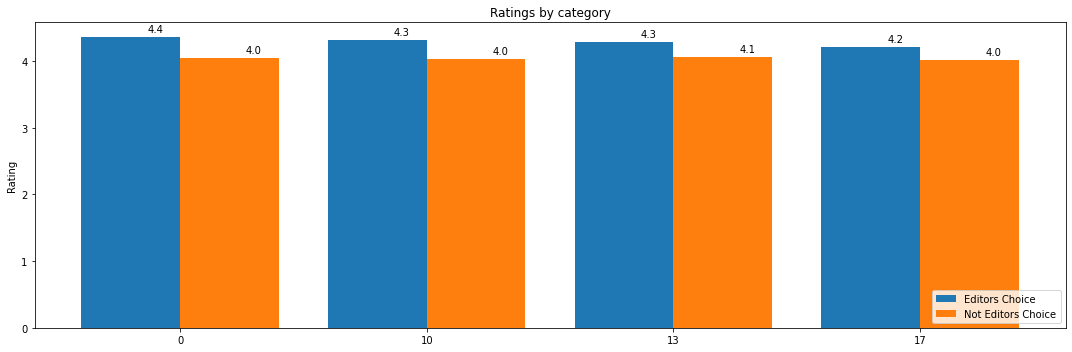

In [78]:
n = 4
y = np.arange(n)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize = (15,5))
rects5 = ax.bar(y-.5*width, editorsT, width, label='Editors Choice')
rects6 = ax.bar(y+.5*width, editorsF, width, label='Not Editors Choice')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rating')
ax.set_title('Ratings by category')
ax.set_xticks(y)
ax.set_xticklabels(labels)
ax.legend(loc = 'lower right')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height.round(1)),
                    xy=(rect.get_x() + rect.get_width() , height),
                    xytext=(-25, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects5)
autolabel(rects6)

fig.tight_layout()

plt.show()